In [1]:
from collections import Counter, defaultdict
import json
import pathlib
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import torch

from data.russia import Russia
from train import train
from utils.training import TrainConfig

/home/pavel/.venv/hse/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/pavel/.venv/hse/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
%matplotlib inline

In [3]:
%precision 2
pd.set_option('display.precision', 2)

In [4]:
sns.set(font_scale=1.25, style="whitegrid")

In [5]:
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [6]:
TIMESTAMPS_PER_MONTH = 10

In [7]:
dumps_path = pathlib.Path("dumps")
if not dumps_path.exists():
    dumps_path.mkdir()

# Plan

## Data

1. Years: 2018–2022.
2. Each year: N fields.
3. Each field:
  - features: time series of 10 Sentinel-2 bands (median value for each field), number of timestamps is different;
  - target: crop class label (13 classes).

## Models

1. Classical ML:
  - Random Forest;
  - Catboost;
  - LightGBM.
2. Deep learning:
  - Transformer;
  - TempCNN;
  - *EarlyRNN*.
 
## Training&evaluation workflow

1. For all models besides EarlyRNN: make datasets of reduced size (1–6 months, where 6 months is full-length time series), train models separately on each of them.
2. For EarlyRNN: train using full-length time series.
3. Compare accuracy, precision, recall, f1-score, kappa.

# Part 0. Dataset statistics

In [7]:
dataset_train = Russia(root="/home/pavel/elects_data/russia/", partition="train", broadcast_y=False)
dataset_test = Russia(root="/home/pavel/elects_data/russia/", partition="test", broadcast_y=False)

Data: train, year: 2018, months: 6
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 6
Loading from cache
# of fields: 2057


In [18]:
crop_classes = pd.read_csv("/home/pavel/elects_data/russia/classmapping.csv")
crop_classes

class_id  class_code      class_name
0          0           1            Corn
1          1           2             Soy
2          2           3       Sunflower
3          3           4          Potato
4          4           5       Sugarbeet
5          5           6     Winter rape
6          6           7     Spring rape
7          7           8            Rice
8          8         101  Winter cereals
9          9         102  Spring cereals
10        10         201            Feed
11        11        1001          Fallow
12        12       10001           Other

In [10]:
dataset_train["X"].shape, dataset_test["X"].shape

((8264, 600), (2057, 600))

In [41]:
cnt_train = Counter(dataset_train["y"])
cnt_test = Counter(dataset_test["y"])
crop_classes_counts_train = pd.DataFrame({
    "class_id": cnt_train.keys(),
    "count_train": cnt_train.values(),
    "sum_train": [100 * val / sum(cnt_train.values()) for val in cnt_train.values()]
    
})
crop_classes_counts_test = pd.DataFrame({
    "class_id": cnt_test.keys(),
    "count_test": cnt_test.values(),
    "share_test": [100 * val / sum(cnt_test.values()) for val in cnt_test.values()]
})
crop_classes_count = crop_classes_counts_train.merge(crop_classes_counts_test)
crop_classes_count

class_id  count_train  sum_train  count_test  share_test
0          8         2379      28.79         594       28.88
1          0          590       7.14         147        7.15
2          9         1442      17.45         360       17.50
3          1          207       2.50          51        2.48
4         12          749       9.06         186        9.04
5          2          635       7.68         158        7.68
6         11          708       8.57         176        8.56
7         10          839      10.15         209       10.16
8          4          182       2.20          45        2.19
9          6          425       5.14         106        5.15
10         5           40       0.48           9        0.44
11         3           68       0.82          16        0.78

In [42]:
crop_classes_stats = crop_classes.merge(crop_classes_count)
crop_classes_stats.drop(columns=["class_code"], inplace=True)
crop_classes_stats.columns = ["Class label", "Crop name", "# in train", "% in train", "# in test", "% in test"]
crop_classes_stats

Class label       Crop name  # in train  % in train  # in test  % in test
0             0            Corn         590        7.14        147       7.15
1             1             Soy         207        2.50         51       2.48
2             2       Sunflower         635        7.68        158       7.68
3             3          Potato          68        0.82         16       0.78
4             4       Sugarbeet         182        2.20         45       2.19
5             5     Winter rape          40        0.48          9       0.44
6             6     Spring rape         425        5.14        106       5.15
7             8  Winter cereals        2379       28.79        594      28.88
8             9  Spring cereals        1442       17.45        360      17.50
9            10            Feed         839       10.15        209      10.16
10           11          Fallow         708        8.57        176       8.56
11           12           Other         749        9.06        186       9.04

In [52]:
print(crop_classes_stats.to_latex(index=False, caption="Crop classes statistics in dataset", label="Table 2.3.1"))

\begin{table}
\centering
\caption{Crop classes statistics in dataset}
\label{Table 2.3.1}
\begin{tabular}{rlrrrr}
\toprule
 Class label &      Crop name &  \# in train &  \% in train &  \# in test &  \% in test \\
\midrule
           0 &           Corn &         590 &        7.14 &        147 &       7.15 \\
           1 &            Soy &         207 &        2.50 &         51 &       2.48 \\
           2 &      Sunflower &         635 &        7.68 &        158 &       7.68 \\
           3 &         Potato &          68 &        0.82 &         16 &       0.78 \\
           4 &      Sugarbeet &         182 &        2.20 &         45 &       2.19 \\
           5 &    Winter rape &          40 &        0.48 &          9 &       0.44 \\
           6 &    Spring rape &         425 &        5.14 &        106 &       5.15 \\
           8 & Winter cereals &        2379 &       28.79 &        594 &      28.88 \\
           9 & Spring cereals &        1442 &       17.45 &        360 &      17.

/tmp/ipykernel_13454/3613067214.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(crop_classes_stats.to_latex(index=False, caption="Crop classes statistics in dataset", label="Table 2.3.1"))


# Part 1. Training

## Classical Machine Learning

### Random Forest

In [22]:
rf_hyperparameters = {
    "n_estimators": range(10, 501, 10),
    "max_depth": range(3, 21),
}

In [1]:
rf_results = defaultdict(dict)

for n_months in range(1, 7):
    sequencelength = n_months * TIMESTAMPS_PER_MONTH
    rf_train_params = TrainConfig(        
        model="rf",
        year=2018,
        n_months=n_months,
        sequencelength=sequencelength,
        hyperparameters=rf_hyperparameters,
        n_iter=100
    )
    best_model, stats = train(rf_train_params)
    rf_results[n_months]["best_model"] = best_model
    rf_results[n_months]["stats"] = stats

NameError: name 'defaultdict' is not defined

In [6]:
with open(dumps_path / "rf_results.dump", "wb") as f:
    pickle.dump(rf_results, f)

### LightGBM

In [ ]:
lgbm_hyperparameters = {
    "boosting_type": ("dart",),
    "n_estimators": range(10, 501, 10),
    "max_depth": range(3, 10),
    "learning_rate": (0.001, 0.01, 0.1, 1),
}

In [5]:
lgbm_results = defaultdict(dict)

for n_months in range(1, 7):
    sequencelength = n_months * TIMESTAMPS_PER_MONTH
    lgbm_train_params = TrainConfig(
        model="lightgbm",
        year=2018,
        n_months=n_months,
        sequencelength=sequencelength,
        hyperparameters=lgbm_hyperparameters,
        n_iter=50
    )
    best_model, stats = train(lgbm_train_params)
    lgbm_results[n_months]["best_model"] = best_model
    lgbm_results[n_months]["stats"] = stats

Data: train, year: 2018, months: 1
Loading from cache
# of fields: 7367
Data: test, year: 2018, months: 1
Loading from cache
# of fields: 1566
X shape: (7367, 100) y shape: (7367,)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.422) fscore: (test=0.391) kappa: (test=0.293) precision: (test=0.389) recall: (test=0.422) total time= 1.0min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.426) fscore: (test=0.410) kappa: (test=0.306) precision: (test=0.404) recall: (test=0.426) total time= 1.7min
[CV 1/3] END boosting_type=dart, learning_rate=0.001, max_depth=7, n_estimators=340; accuracy: (test=0.374) fscore: (test=0.274) kappa: (test=0.161) precision: (test=0.302) recall: (test=0.374) total time= 2.3min
[CV 3/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.436) fscore: (test=

[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.413) fscore: (test=0.369) kappa: (test=0.279) precision: (test=0.358) recall: (test=0.413) total time= 1.1min
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.420) fscore: (test=0.396) kappa: (test=0.294) precision: (test=0.396) recall: (test=0.420) total time= 1.6min
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.436) fscore: (test=0.400) kappa: (test=0.309) precision: (test=0.408) recall: (test=0.436) total time= 1.4min
[CV 1/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.409) fscore: (test=0.378) kappa: (test=0.281) precision: (test=0.376) recall: (test=0.409) total time=  34.6s
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.446) fscore: (test=0.428) kappa: (test=0.329) precis

X shape: (8264, 200) y shape: (8264,)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.431) fscore: (test=0.413) kappa: (test=0.310) precision: (test=0.408) recall: (test=0.431) total time= 1.1min
[CV 1/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.315) fscore: (test=0.154) kappa: (test=0.004) precision: (test=0.148) recall: (test=0.315) total time=  43.5s
[CV 3/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.321) fscore: (test=0.166) kappa: (test=0.016) precision: (test=0.166) recall: (test=0.321) total time=  41.6s
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.428) fscore: (test=0.407) kappa: (test=0.306) precision: (test=0.402) recall: (test=0.428) total time= 1.4min
[CV 3/3] END boosting_type=dart, learning_rate=0.0

[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=50; accuracy: (test=0.316) fscore: (test=0.157) kappa: (test=0.007) precision: (test=0.212) recall: (test=0.316) total time=   5.5s
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=50; accuracy: (test=0.331) fscore: (test=0.187) kappa: (test=0.038) precision: (test=0.231) recall: (test=0.331) total time=   5.5s
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=8, n_estimators=90; accuracy: (test=0.442) fscore: (test=0.424) kappa: (test=0.323) precision: (test=0.416) recall: (test=0.442) total time=  30.6s
[CV 3/3] END boosting_type=dart, learning_rate=0.1, max_depth=9, n_estimators=490; accuracy: (test=0.424) fscore: (test=0.407) kappa: (test=0.303) precision: (test=0.421) recall: (test=0.424) total time= 3.7min
[CV 1/3] END boosting_type=dart, learning_rate=0.1, max_depth=4, n_estimators=70; accuracy: (test=0.410) fscore: (test=0.377) kappa: (test=0.281) precision: 

Fitting best model on whole train dataset
[CV 3/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.454) fscore: (test=0.442) kappa: (test=0.349) precision: (test=0.449) recall: (test=0.454) total time= 1.0min
[CV 2/3] END boosting_type=dart, learning_rate=0.001, max_depth=7, n_estimators=90; accuracy: (test=0.288) fscore: (test=0.129) kappa: (test=0.000) precision: (test=0.083) recall: (test=0.288) total time=  56.6s
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=6, n_estimators=180; accuracy: (test=0.488) fscore: (test=0.463) kappa: (test=0.381) precision: (test=0.461) recall: (test=0.488) total time= 2.0min
[CV 3/3] END boosting_type=dart, learning_rate=0.1, max_depth=7, n_estimators=400; accuracy: (test=0.122) fscore: (test=0.061) kappa: (test=0.015) precision: (test=0.108) recall: (test=0.122) total time= 4.7min
[CV 1/3] END boosting_type=dart, learning_rate=0.1, max_depth=8, n_estimators=350; accuracy: (test=0.490) fscore:

[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=70; accuracy: (test=0.467) fscore: (test=0.437) kappa: (test=0.355) precision: (test=0.426) recall: (test=0.467) total time=  16.0s
[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=310; accuracy: (test=0.450) fscore: (test=0.390) kappa: (test=0.321) precision: (test=0.395) recall: (test=0.450) total time= 1.3min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=180; accuracy: (test=0.438) fscore: (test=0.373) kappa: (test=0.299) precision: (test=0.389) recall: (test=0.438) total time=  42.9s
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=6, n_estimators=330; accuracy: (test=0.441) fscore: (test=0.426) kappa: (test=0.332) precision: (test=0.436) recall: (test=0.441) total time= 3.7min
[CV 2/3] END boosting_type=dart, learning_rate=0.001, max_depth=8, n_estimators=50; accuracy: (test=0.288) fscore: (test=0.129) kappa: (test=0.000) precis

[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.480) fscore: (test=0.463) kappa: (test=0.376) precision: (test=0.470) recall: (test=0.480) total time= 3.6min
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.484) fscore: (test=0.471) kappa: (test=0.385) precision: (test=0.479) recall: (test=0.484) total time= 5.4min
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.479) fscore: (test=0.464) kappa: (test=0.378) precision: (test=0.475) recall: (test=0.479) total time= 4.1min
[CV 1/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.588) fscore: (test=0.562) kappa: (test=0.502) precision: (test=0.570) recall: (test=0.588) total time= 1.7min
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.555) fscore: (test=0.534) kappa: (test=0.462) precis

Fitting best model on whole train dataset
[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.552) fscore: (test=0.522) kappa: (test=0.455) precision: (test=0.530) recall: (test=0.552) total time= 3.5min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.527) fscore: (test=0.504) kappa: (test=0.425) precision: (test=0.513) recall: (test=0.527) total time= 5.4min
[CV 1/3] END boosting_type=dart, learning_rate=0.001, max_depth=7, n_estimators=340; accuracy: (test=0.482) fscore: (test=0.428) kappa: (test=0.346) precision: (test=0.462) recall: (test=0.482) total time= 6.7min
[CV 3/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.505) fscore: (test=0.496) kappa: (test=0.411) precision: (test=0.507) recall: (test=0.505) total time= 1.7min
[CV 2/3] END boosting_type=dart, learning_rate=0.001, max_depth=7, n_estimators=90; accuracy: (test=0.288) fsc

[CV 3/3] END boosting_type=dart, learning_rate=0.001, max_depth=4, n_estimators=270; accuracy: (test=0.414) fscore: (test=0.331) kappa: (test=0.242) precision: (test=0.420) recall: (test=0.414) total time= 1.8min
Data: train, year: 2018, months: 4
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 4
Loading from cache
# of fields: 2057
X shape: (8264, 400) y shape: (8264,)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.585) fscore: (test=0.570) kappa: (test=0.506) precision: (test=0.583) recall: (test=0.585) total time= 4.0min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.618) fscore: (test=0.600) kappa: (test=0.541) precision: (test=0.604) recall: (test=0.618) total time= 6.4min
[CV 1/3] END boosting_type=dart, learning_rate=0.001, max_depth=7, n_estimators=340; accuracy: (test=0.561) fscore: (tes

[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.616) fscore: (test=0.587) kappa: (test=0.533) precision: (test=0.591) recall: (test=0.616) total time= 4.2min
[CV 1/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.306) fscore: (test=0.164) kappa: (test=0.033) precision: (test=0.258) recall: (test=0.306) total time= 2.6min
[CV 3/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.302) fscore: (test=0.157) kappa: (test=0.024) precision: (test=0.199) recall: (test=0.302) total time= 2.4min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.604) fscore: (test=0.583) kappa: (test=0.524) precision: (test=0.588) recall: (test=0.604) total time= 5.1min
[CV 3/3] END boosting_type=dart, learning_rate=0.001, max_depth=7, n_estimators=340; accuracy: (test=0.542) fscore: (test=0.504) kappa: (test=0.434) p

[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.595) fscore: (test=0.575) kappa: (test=0.511) precision: (test=0.578) recall: (test=0.595) total time= 4.1min
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.589) fscore: (test=0.577) kappa: (test=0.512) precision: (test=0.588) recall: (test=0.589) total time= 5.8min
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.586) fscore: (test=0.569) kappa: (test=0.508) precision: (test=0.574) recall: (test=0.586) total time= 4.7min
[CV 1/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.668) fscore: (test=0.644) kappa: (test=0.600) precision: (test=0.643) recall: (test=0.668) total time= 2.0min
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.643) fscore: (test=0.626) kappa: (test=0.571) precis

[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.637) fscore: (test=0.612) kappa: (test=0.561) precision: (test=0.614) recall: (test=0.637) total time= 6.4min
[CV 2/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.298) fscore: (test=0.149) kappa: (test=0.016) precision: (test=0.272) recall: (test=0.298) total time= 2.5min
[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.638) fscore: (test=0.611) kappa: (test=0.562) precision: (test=0.613) recall: (test=0.638) total time= 5.0min
[CV 2/3] END boosting_type=dart, learning_rate=0.001, max_depth=7, n_estimators=340; accuracy: (test=0.519) fscore: (test=0.477) kappa: (test=0.395) precision: (test=0.523) recall: (test=0.519) total time= 7.8min
[CV 1/3] END boosting_type=dart, learning_rate=0.1, max_depth=6, n_estimators=180; accuracy: (test=0.676) fscore: (test=0.656) kappa: (test=0.610) pre

[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.652) fscore: (test=0.631) kappa: (test=0.578) precision: (test=0.642) recall: (test=0.652) total time= 5.1min
[CV 1/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.301) fscore: (test=0.156) kappa: (test=0.026) precision: (test=0.286) recall: (test=0.301) total time= 3.1min
[CV 3/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.316) fscore: (test=0.188) kappa: (test=0.049) precision: (test=0.357) recall: (test=0.316) total time= 3.2min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.642) fscore: (test=0.627) kappa: (test=0.570) precision: (test=0.635) recall: (test=0.642) total time= 6.2min
[CV 3/3] END boosting_type=dart, learning_rate=0.001, max_depth=7, n_estimators=340; accuracy: (test=0.563) fscore: (test=0.522) kappa: (test=0.459) p

[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=9, n_estimators=490; accuracy: (test=0.717) fscore: (test=0.703) kappa: (test=0.661) precision: (test=0.708) recall: (test=0.717) total time=15.7min
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=4, n_estimators=70; accuracy: (test=0.671) fscore: (test=0.655) kappa: (test=0.606) precision: (test=0.661) recall: (test=0.671) total time=  56.0s
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.626) fscore: (test=0.612) kappa: (test=0.552) precision: (test=0.628) recall: (test=0.626) total time= 4.7min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.651) fscore: (test=0.634) kappa: (test=0.581) precision: (test=0.638) recall: (test=0.651) total time= 7.4min
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.621) fscore: (test=0.608) kappa: (test=0.547) precisi

Fitting best model on whole train dataset
Data: train, year: 2018, months: 6
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 6
Loading from cache
# of fields: 2057
X shape: (8264, 600) y shape: (8264,)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.658) fscore: (test=0.638) kappa: (test=0.585) precision: (test=0.649) recall: (test=0.658) total time= 5.8min
[CV 1/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.296) fscore: (test=0.145) kappa: (test=0.014) precision: (test=0.171) recall: (test=0.296) total time= 3.6min
[CV 3/3] END boosting_type=dart, learning_rate=0.001, max_depth=5, n_estimators=160; accuracy: (test=0.317) fscore: (test=0.189) kappa: (test=0.050) precision: (test=0.346) recall: (test=0.317) total time= 3.6min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimator

[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=160; accuracy: (test=0.623) fscore: (test=0.609) kappa: (test=0.549) precision: (test=0.623) recall: (test=0.623) total time= 5.7min
[CV 2/3] END boosting_type=dart, learning_rate=0.01, max_depth=8, n_estimators=250; accuracy: (test=0.655) fscore: (test=0.642) kappa: (test=0.585) precision: (test=0.647) recall: (test=0.655) total time= 8.8min
[CV 3/3] END boosting_type=dart, learning_rate=0.01, max_depth=5, n_estimators=290; accuracy: (test=0.632) fscore: (test=0.619) kappa: (test=0.561) precision: (test=0.634) recall: (test=0.632) total time= 6.9min
[CV 1/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.719) fscore: (test=0.711) kappa: (test=0.664) precision: (test=0.717) recall: (test=0.719) total time= 2.7min
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=250; accuracy: (test=0.681) fscore: (test=0.668) kappa: (test=0.618) precis

[CV 3/3] END boosting_type=dart, learning_rate=0.1, max_depth=9, n_estimators=490; accuracy: (test=0.682) fscore: (test=0.679) kappa: (test=0.622) precision: (test=0.695) recall: (test=0.682) total time=18.5min
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=4, n_estimators=70; accuracy: (test=0.669) fscore: (test=0.657) kappa: (test=0.604) precision: (test=0.660) recall: (test=0.669) total time= 1.1min
[CV 1/3] END boosting_type=dart, learning_rate=0.1, max_depth=5, n_estimators=120; accuracy: (test=0.709) fscore: (test=0.699) kappa: (test=0.650) precision: (test=0.708) recall: (test=0.709) total time= 3.0min
[CV 2/3] END boosting_type=dart, learning_rate=0.1, max_depth=5, n_estimators=120; accuracy: (test=0.682) fscore: (test=0.669) kappa: (test=0.618) precision: (test=0.672) recall: (test=0.682) total time= 2.9min
[CV 3/3] END boosting_type=dart, learning_rate=0.1, max_depth=5, n_estimators=120; accuracy: (test=0.655) fscore: (test=0.650) kappa: (test=0.589) precision:

In [6]:
with open(dumps_path / "lgbm_results.dump", "wb") as f:
    pickle.dump(lgbm_results, f)

### Catboost

In [16]:
catboost_hyperparameters = {
    "iterations": range(10, 201, 20),
    "depth": range(3, 7),
    #"learning_rate": (0.001, 0.01, 0.1, 1),
}

In [6]:
catboost_results = defaultdict(dict)

for n_months in range(1, 7):
    sequencelength = n_months * TIMESTAMPS_PER_MONTH
    catboost_train_params = TrainConfig(
        model="catboost",
        year=2018,
        n_months=n_months,
        sequencelength=sequencelength,
        hyperparameters=catboost_hyperparameters,
        n_iter=20
    )
    best_model, stats = train(catboost_train_params)
    catboost_results[n_months]["best_model"] = best_model
    catboost_results[n_months]["stats"] = stats

Data: train, year: 2018, months: 1
Loading from cache
# of fields: 7367
Data: test, year: 2018, months: 1
Loading from cache
# of fields: 1566
X shape: (7367, 100) y shape: (7367,)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Learning rate set to 0.349161
0:	learn: 1.9475597	total: 71.3ms	remaining: 13.5s
50:	learn: 1.2807169	total: 3.86s	remaining: 10.5s
100:	learn: 1.0906627	total: 7.57s	remaining: 6.67s
150:	learn: 0.9673981	total: 10.8s	remaining: 2.8s
189:	learn: 0.8890186	total: 13.4s	remaining: 0us
[CV 1/3] END depth=4, iterations=190; accuracy: (test=0.411) fscore: (test=0.379) kappa: (test=0.283) precision: (test=0.375) recall: (test=0.411) total time=  14.0s
Learning rate set to 0.349161
0:	learn: 1.9096427	total: 81.8ms	remaining: 15.5s
50:	learn: 1.3037441	total: 3.88s	remaining: 10.6s
100:	learn: 1.1179169	total: 7.25s	remaining: 6.39s
150:	learn: 0.9857955	total: 10.9s	remaining: 2.82s
189:	learn: 0.8955443	total: 13.8s	remaining: 0us
[CV 2/3] END depth=4,

Learning rate set to 0.426359
0:	learn: 1.9042607	total: 153ms	remaining: 22.8s
50:	learn: 1.1178008	total: 6.73s	remaining: 13.1s
100:	learn: 0.9142980	total: 13.4s	remaining: 6.53s
149:	learn: 0.7417222	total: 20.7s	remaining: 0us
[CV 1/3] END depth=5, iterations=150; accuracy: (test=0.411) fscore: (test=0.382) kappa: (test=0.284) precision: (test=0.378) recall: (test=0.411) total time=  21.6s
Learning rate set to 0.426359
0:	learn: 1.8686025	total: 188ms	remaining: 28.1s
50:	learn: 1.1565300	total: 7.65s	remaining: 14.9s
100:	learn: 0.9130815	total: 14.1s	remaining: 6.86s
149:	learn: 0.7435852	total: 21s	remaining: 0us
[CV 2/3] END depth=5, iterations=150; accuracy: (test=0.430) fscore: (test=0.422) kappa: (test=0.314) precision: (test=0.422) recall: (test=0.430) total time=  21.7s
Learning rate set to 0.426364
0:	learn: 1.8784556	total: 169ms	remaining: 25.2s
50:	learn: 1.0684291	total: 7.57s	remaining: 14.7s
100:	learn: 0.8277084	total: 14.5s	remaining: 7.04s
149:	learn: 0.6710772

50:	learn: 0.9782099	total: 13.8s	remaining: 10.6s
89:	learn: 0.7543445	total: 22.4s	remaining: 0us
[CV 1/3] END depth=6, iterations=90; accuracy: (test=0.405) fscore: (test=0.377) kappa: (test=0.277) precision: (test=0.376) recall: (test=0.405) total time=  22.9s
Learning rate set to 0.5
0:	learn: 1.8348994	total: 223ms	remaining: 19.8s
50:	learn: 0.9945980	total: 11.5s	remaining: 8.78s
89:	learn: 0.7600634	total: 21.6s	remaining: 0us
[CV 2/3] END depth=6, iterations=90; accuracy: (test=0.426) fscore: (test=0.419) kappa: (test=0.311) precision: (test=0.417) recall: (test=0.426) total time=  22.2s
Learning rate set to 0.5
0:	learn: 1.8095073	total: 278ms	remaining: 24.7s
50:	learn: 0.9330052	total: 11.1s	remaining: 8.53s
89:	learn: 0.7164238	total: 19.6s	remaining: 0us
[CV 3/3] END depth=6, iterations=90; accuracy: (test=0.392) fscore: (test=0.384) kappa: (test=0.267) precision: (test=0.394) recall: (test=0.392) total time=  20.1s
Learning rate set to 0.383569
0:	learn: 1.9266915	total

50:	learn: 1.0467441	total: 5.87s	remaining: 16s
100:	learn: 0.8463658	total: 11.5s	remaining: 10.2s
150:	learn: 0.7199698	total: 17.3s	remaining: 4.46s
189:	learn: 0.6474709	total: 21.7s	remaining: 0us
[CV 3/3] END depth=4, iterations=190; accuracy: (test=0.436) fscore: (test=0.430) kappa: (test=0.330) precision: (test=0.440) recall: (test=0.436) total time=  22.6s
Learning rate set to 0.483989
0:	learn: 1.8800504	total: 139ms	remaining: 17.9s
50:	learn: 1.0898626	total: 5.85s	remaining: 9.06s
100:	learn: 0.8726578	total: 11.5s	remaining: 3.31s
129:	learn: 0.7887243	total: 14.8s	remaining: 0us
[CV 1/3] END depth=4, iterations=130; accuracy: (test=0.458) fscore: (test=0.433) kappa: (test=0.348) precision: (test=0.427) recall: (test=0.458) total time=  15.7s
Learning rate set to 0.483989
0:	learn: 1.8754430	total: 134ms	remaining: 17.2s
50:	learn: 1.0380705	total: 5.83s	remaining: 9.02s
100:	learn: 0.8236470	total: 11.6s	remaining: 3.32s
129:	learn: 0.7383743	total: 14.9s	remaining: 0us

Learning rate set to 0.351213
0:	learn: 1.9163032	total: 453ms	remaining: 1m 25s
50:	learn: 0.9472973	total: 22.4s	remaining: 1m
100:	learn: 0.6862908	total: 44.2s	remaining: 39s
150:	learn: 0.5260370	total: 1m 6s	remaining: 17.1s
189:	learn: 0.4325355	total: 1m 23s	remaining: 0us
[CV 1/3] END depth=6, iterations=190; accuracy: (test=0.470) fscore: (test=0.442) kappa: (test=0.361) precision: (test=0.439) recall: (test=0.470) total time= 1.4min
Learning rate set to 0.351213
0:	learn: 1.8991389	total: 443ms	remaining: 1m 23s
50:	learn: 0.9141644	total: 22.3s	remaining: 1m
100:	learn: 0.6559938	total: 43.9s	remaining: 38.7s
150:	learn: 0.4898845	total: 1m 5s	remaining: 17s
189:	learn: 0.3962552	total: 1m 22s	remaining: 0us
[CV 2/3] END depth=6, iterations=190; accuracy: (test=0.477) fscore: (test=0.453) kappa: (test=0.367) precision: (test=0.449) recall: (test=0.477) total time= 1.4min
Learning rate set to 0.351217
0:	learn: 1.8740395	total: 441ms	remaining: 1m 23s
50:	learn: 0.8541600	to

169:	learn: 0.9530322	total: 10.5s	remaining: 0us
[CV 1/3] END depth=3, iterations=170; accuracy: (test=0.479) fscore: (test=0.449) kappa: (test=0.372) precision: (test=0.439) recall: (test=0.479) total time=  11.5s
Learning rate set to 0.385823
0:	learn: 1.9490670	total: 71.8ms	remaining: 12.1s
50:	learn: 1.2256607	total: 3.25s	remaining: 7.57s
100:	learn: 1.0533548	total: 6.39s	remaining: 4.37s
150:	learn: 0.9443273	total: 9.5s	remaining: 1.2s
169:	learn: 0.9111025	total: 10.7s	remaining: 0us
[CV 2/3] END depth=3, iterations=170; accuracy: (test=0.471) fscore: (test=0.447) kappa: (test=0.361) precision: (test=0.440) recall: (test=0.471) total time=  11.6s
Learning rate set to 0.385827
0:	learn: 1.8944388	total: 77.6ms	remaining: 13.1s
50:	learn: 1.1305340	total: 3.27s	remaining: 7.64s
100:	learn: 0.9589371	total: 6.42s	remaining: 4.38s
150:	learn: 0.8592351	total: 9.5s	remaining: 1.2s
169:	learn: 0.8297306	total: 10.7s	remaining: 0us
[CV 3/3] END depth=3, iterations=170; accuracy: (t

Learning rate set to 0.483994
0:	learn: 1.7734574	total: 212ms	remaining: 27.3s
50:	learn: 0.8229643	total: 8.51s	remaining: 13.2s
100:	learn: 0.6172906	total: 16.8s	remaining: 4.81s
129:	learn: 0.5532383	total: 21.6s	remaining: 0us
[CV 3/3] END depth=4, iterations=130; accuracy: (test=0.482) fscore: (test=0.479) kappa: (test=0.386) precision: (test=0.487) recall: (test=0.482) total time=  22.7s
Learning rate set to 0.5
0:	learn: 1.8075316	total: 224ms	remaining: 24.4s
50:	learn: 0.9894696	total: 8.55s	remaining: 9.89s
100:	learn: 0.7717007	total: 16.8s	remaining: 1.5s
109:	learn: 0.7390411	total: 18.4s	remaining: 0us
[CV 1/3] END depth=4, iterations=110; accuracy: (test=0.555) fscore: (test=0.535) kappa: (test=0.465) precision: (test=0.536) recall: (test=0.555) total time=  19.6s
Learning rate set to 0.5
0:	learn: 1.8521688	total: 204ms	remaining: 22.2s
50:	learn: 0.9305164	total: 8.46s	remaining: 9.78s
100:	learn: 0.7316286	total: 16.7s	remaining: 1.49s
109:	learn: 0.7016471	total: 1

189:	learn: 0.2739219	total: 2m 19s	remaining: 0us
[CV 3/3] END depth=6, iterations=190; accuracy: (test=0.468) fscore: (test=0.467) kappa: (test=0.370) precision: (test=0.478) recall: (test=0.468) total time= 2.4min
Learning rate set to 0.483989
0:	learn: 1.8545451	total: 226ms	remaining: 29.1s
50:	learn: 1.0958490	total: 5.88s	remaining: 9.11s
100:	learn: 0.9265457	total: 11.4s	remaining: 3.27s
129:	learn: 0.8626054	total: 15.1s	remaining: 0us
[CV 1/3] END depth=3, iterations=130; accuracy: (test=0.558) fscore: (test=0.532) kappa: (test=0.468) precision: (test=0.527) recall: (test=0.558) total time=  16.4s
Learning rate set to 0.483989
0:	learn: 1.9010306	total: 210ms	remaining: 27.1s
50:	learn: 1.0438074	total: 6.7s	remaining: 10.4s
100:	learn: 0.8612116	total: 13.9s	remaining: 3.98s
129:	learn: 0.7886541	total: 17.5s	remaining: 0us
[CV 2/3] END depth=3, iterations=130; accuracy: (test=0.540) fscore: (test=0.525) kappa: (test=0.447) precision: (test=0.524) recall: (test=0.540) total

Learning rate set to 0.428865
0:	learn: 1.8336605	total: 211ms	remaining: 31.4s
50:	learn: 0.9985866	total: 8.54s	remaining: 16.6s
100:	learn: 0.7970174	total: 16.7s	remaining: 8.09s
149:	learn: 0.6702356	total: 24.6s	remaining: 0us
[CV 1/3] END depth=4, iterations=150; accuracy: (test=0.568) fscore: (test=0.546) kappa: (test=0.481) precision: (test=0.544) recall: (test=0.568) total time=  25.8s
Learning rate set to 0.428865
0:	learn: 1.8757731	total: 202ms	remaining: 30.1s
50:	learn: 0.9560831	total: 8.48s	remaining: 16.5s
100:	learn: 0.7609696	total: 16.6s	remaining: 8.07s
149:	learn: 0.6314470	total: 24.6s	remaining: 0us
[CV 2/3] END depth=4, iterations=150; accuracy: (test=0.542) fscore: (test=0.524) kappa: (test=0.449) precision: (test=0.524) recall: (test=0.542) total time=  25.7s
Learning rate set to 0.428869
0:	learn: 1.7928669	total: 206ms	remaining: 30.7s
50:	learn: 0.8295499	total: 8.78s	remaining: 17s
100:	learn: 0.6356595	total: 18s	remaining: 8.71s
149:	learn: 0.5199679	t

Learning rate set to 0.5
0:	learn: 1.7429349	total: 271ms	remaining: 29.6s
50:	learn: 0.6625608	total: 11.1s	remaining: 12.8s
100:	learn: 0.4616491	total: 21.9s	remaining: 1.95s
109:	learn: 0.4385620	total: 23.9s	remaining: 0us
[CV 3/3] END depth=4, iterations=110; accuracy: (test=0.575) fscore: (test=0.571) kappa: (test=0.496) precision: (test=0.582) recall: (test=0.575) total time=  25.3s
Learning rate set to 0.483989
0:	learn: 1.7908722	total: 508ms	remaining: 1m 5s
50:	learn: 0.6891814	total: 21.6s	remaining: 33.5s
100:	learn: 0.4887575	total: 42.6s	remaining: 12.2s
129:	learn: 0.4120538	total: 54.8s	remaining: 0us
[CV 1/3] END depth=5, iterations=130; accuracy: (test=0.626) fscore: (test=0.610) kappa: (test=0.551) precision: (test=0.609) recall: (test=0.626) total time=  56.3s
Learning rate set to 0.483989
0:	learn: 1.7232366	total: 518ms	remaining: 1m 6s
50:	learn: 0.6390466	total: 21.5s	remaining: 33.4s
100:	learn: 0.4356635	total: 42.6s	remaining: 12.2s
129:	learn: 0.3654233	to

129:	learn: 0.5453802	total: 15.1s	remaining: 0us
[CV 3/3] END depth=3, iterations=130; accuracy: (test=0.595) fscore: (test=0.590) kappa: (test=0.520) precision: (test=0.600) recall: (test=0.595) total time=  16.6s
Learning rate set to 0.5
0:	learn: 1.7850304	total: 515ms	remaining: 56.2s
50:	learn: 0.6797887	total: 21.6s	remaining: 24.9s
100:	learn: 0.4865018	total: 42.4s	remaining: 3.78s
109:	learn: 0.4612689	total: 46.2s	remaining: 0us
[CV 1/3] END depth=5, iterations=110; accuracy: (test=0.648) fscore: (test=0.627) kappa: (test=0.577) precision: (test=0.625) recall: (test=0.648) total time=  47.7s
Learning rate set to 0.5
0:	learn: 1.7170900	total: 512ms	remaining: 55.8s
50:	learn: 0.6078491	total: 21.6s	remaining: 25s
100:	learn: 0.4203380	total: 42.4s	remaining: 3.78s
109:	learn: 0.3950304	total: 46.2s	remaining: 0us
[CV 2/3] END depth=5, iterations=110; accuracy: (test=0.603) fscore: (test=0.595) kappa: (test=0.527) precision: (test=0.594) recall: (test=0.603) total time=  47.7

Learning rate set to 0.5
0:	learn: 1.7850304	total: 508ms	remaining: 45.2s
50:	learn: 0.6797887	total: 21.5s	remaining: 16.5s
89:	learn: 0.5125580	total: 37.8s	remaining: 0us
[CV 1/3] END depth=5, iterations=90; accuracy: (test=0.646) fscore: (test=0.624) kappa: (test=0.574) precision: (test=0.622) recall: (test=0.646) total time=  39.3s
Learning rate set to 0.5
0:	learn: 1.7170900	total: 514ms	remaining: 45.8s
50:	learn: 0.6078491	total: 21.6s	remaining: 16.5s
89:	learn: 0.4586185	total: 37.8s	remaining: 0us
[CV 2/3] END depth=5, iterations=90; accuracy: (test=0.592) fscore: (test=0.583) kappa: (test=0.514) precision: (test=0.582) recall: (test=0.592) total time=  39.3s
Learning rate set to 0.5
0:	learn: 1.7095349	total: 523ms	remaining: 46.6s
50:	learn: 0.5452386	total: 21.7s	remaining: 16.6s
89:	learn: 0.3947625	total: 37.9s	remaining: 0us
[CV 3/3] END depth=5, iterations=90; accuracy: (test=0.572) fscore: (test=0.572) kappa: (test=0.495) precision: (test=0.588) recall: (test=0.572)

Learning rate set to 0.483994
0:	learn: 1.7074867	total: 618ms	remaining: 1m 19s
50:	learn: 0.5015370	total: 25.8s	remaining: 40s
100:	learn: 0.3597334	total: 50.7s	remaining: 14.6s
129:	learn: 0.2959226	total: 1m 5s	remaining: 0us
[CV 3/3] END depth=5, iterations=130; accuracy: (test=0.619) fscore: (test=0.616) kappa: (test=0.548) precision: (test=0.628) recall: (test=0.619) total time= 1.1min
Learning rate set to 0.5
0:	learn: 1.8725347	total: 181ms	remaining: 16.1s
50:	learn: 0.8628221	total: 7.42s	remaining: 5.67s
89:	learn: 0.7281355	total: 13s	remaining: 0us
[CV 1/3] END depth=3, iterations=90; accuracy: (test=0.666) fscore: (test=0.655) kappa: (test=0.600) precision: (test=0.655) recall: (test=0.666) total time=  14.7s
Learning rate set to 0.5
0:	learn: 1.8443677	total: 177ms	remaining: 15.7s
50:	learn: 0.7900603	total: 7.41s	remaining: 5.67s
89:	learn: 0.6516387	total: 13s	remaining: 0us
[CV 2/3] END depth=3, iterations=90; accuracy: (test=0.638) fscore: (test=0.624) kappa: (te

109:	learn: 0.3250734	total: 54.7s	remaining: 0us
[CV 3/3] END depth=5, iterations=110; accuracy: (test=0.621) fscore: (test=0.618) kappa: (test=0.550) precision: (test=0.629) recall: (test=0.621) total time=  56.5s
Learning rate set to 0.351213
0:	learn: 1.9338840	total: 179ms	remaining: 33.8s
50:	learn: 0.9095708	total: 7.58s	remaining: 20.6s
100:	learn: 0.7505634	total: 14.8s	remaining: 13s
150:	learn: 0.6621328	total: 21.8s	remaining: 5.64s
189:	learn: 0.6097617	total: 27.3s	remaining: 0us
[CV 1/3] END depth=3, iterations=190; accuracy: (test=0.687) fscore: (test=0.678) kappa: (test=0.626) precision: (test=0.680) recall: (test=0.687) total time=  29.2s
Learning rate set to 0.351213
0:	learn: 1.9180096	total: 178ms	remaining: 33.7s
50:	learn: 0.8352339	total: 7.46s	remaining: 20.3s
100:	learn: 0.6786860	total: 14.6s	remaining: 12.9s
150:	learn: 0.6046372	total: 21.6s	remaining: 5.59s
189:	learn: 0.5494696	total: 27.2s	remaining: 0us
[CV 2/3] END depth=3, iterations=190; accuracy: (t

Learning rate set to 0.5
0:	learn: 1.8443677	total: 175ms	remaining: 1.58s
9:	learn: 1.2245184	total: 1.51s	remaining: 0us
[CV 2/3] END depth=3, iterations=10; accuracy: (test=0.518) fscore: (test=0.500) kappa: (test=0.420) precision: (test=0.505) recall: (test=0.518) total time=   3.1s
Learning rate set to 0.5
0:	learn: 1.8246981	total: 178ms	remaining: 1.6s
9:	learn: 1.1766410	total: 1.51s	remaining: 0us
[CV 3/3] END depth=3, iterations=10; accuracy: (test=0.504) fscore: (test=0.485) kappa: (test=0.407) precision: (test=0.502) recall: (test=0.504) total time=   3.2s
Learning rate set to 0.5
0:	learn: 1.7245687	total: 1.07s	remaining: 1m 13s
50:	learn: 0.5213667	total: 53.4s	remaining: 19.9s
69:	learn: 0.4299329	total: 1m 13s	remaining: 0us
[CV 1/3] END depth=6, iterations=70; accuracy: (test=0.659) fscore: (test=0.649) kappa: (test=0.592) precision: (test=0.652) recall: (test=0.659) total time= 1.2min
Learning rate set to 0.5
0:	learn: 1.6897728	total: 1.1s	remaining: 1m 15s
50:	lear

[CV 3/3] END depth=3, iterations=90; accuracy: (test=0.609) fscore: (test=0.603) kappa: (test=0.535) precision: (test=0.617) recall: (test=0.609) total time=  17.2s
Learning rate set to 0.5
0:	learn: 1.7956823	total: 396ms	remaining: 19.4s
49:	learn: 0.7317373	total: 15.7s	remaining: 0us
[CV 1/3] END depth=4, iterations=50; accuracy: (test=0.659) fscore: (test=0.647) kappa: (test=0.591) precision: (test=0.648) recall: (test=0.659) total time=  17.8s
Learning rate set to 0.5
0:	learn: 1.7628917	total: 392ms	remaining: 19.2s
49:	learn: 0.6615028	total: 15.7s	remaining: 0us
[CV 2/3] END depth=4, iterations=50; accuracy: (test=0.621) fscore: (test=0.610) kappa: (test=0.547) precision: (test=0.611) recall: (test=0.621) total time=  17.7s
Learning rate set to 0.5
0:	learn: 1.7896111	total: 392ms	remaining: 19.2s
49:	learn: 0.5798517	total: 15.6s	remaining: 0us
[CV 3/3] END depth=4, iterations=50; accuracy: (test=0.610) fscore: (test=0.605) kappa: (test=0.537) precision: (test=0.623) recall: 

100:	learn: 0.5918325	total: 17.3s	remaining: 15.2s
150:	learn: 0.5189714	total: 25.6s	remaining: 6.61s
189:	learn: 0.4762188	total: 32.1s	remaining: 0us
[CV 3/3] END depth=3, iterations=190; accuracy: (test=0.627) fscore: (test=0.621) kappa: (test=0.557) precision: (test=0.632) recall: (test=0.627) total time=  34.1s
Learning rate set to 0.5
0:	learn: 1.7956823	total: 396ms	remaining: 27.3s
50:	learn: 0.7290272	total: 15.9s	remaining: 5.91s
69:	learn: 0.6555133	total: 21.6s	remaining: 0us
[CV 1/3] END depth=4, iterations=70; accuracy: (test=0.661) fscore: (test=0.650) kappa: (test=0.593) precision: (test=0.650) recall: (test=0.661) total time=  23.6s
Learning rate set to 0.5
0:	learn: 1.7628917	total: 397ms	remaining: 27.4s
50:	learn: 0.6518102	total: 16s	remaining: 5.96s
69:	learn: 0.5814132	total: 21.7s	remaining: 0us
[CV 2/3] END depth=4, iterations=70; accuracy: (test=0.633) fscore: (test=0.622) kappa: (test=0.561) precision: (test=0.624) recall: (test=0.633) total time=  23.7s
Le

Learning rate set to 0.5
0:	learn: 1.7054245	total: 1.31s	remaining: 1m 30s
50:	learn: 0.4209484	total: 1m 4s	remaining: 24s
69:	learn: 0.3395856	total: 1m 28s	remaining: 0us
[CV 3/3] END depth=6, iterations=70; accuracy: (test=0.601) fscore: (test=0.597) kappa: (test=0.527) precision: (test=0.611) recall: (test=0.601) total time= 1.5min
Learning rate set to 0.358553
0:	learn: 1.8247621	total: 445ms	remaining: 1m 24s
50:	learn: 0.7824923	total: 17.3s	remaining: 47.2s
100:	learn: 0.6228127	total: 33.7s	remaining: 29.7s
150:	learn: 0.5353553	total: 50s	remaining: 12.9s
189:	learn: 0.4826173	total: 1m 2s	remaining: 0us
Fitting best model on whole train dataset
Learning rate set to 0.358553
0:	learn: 1.8247621	total: 446ms	remaining: 1m 24s
50:	learn: 0.7824923	total: 17.4s	remaining: 47.5s
100:	learn: 0.6228127	total: 33.8s	remaining: 29.8s
150:	learn: 0.5353553	total: 50.1s	remaining: 12.9s
189:	learn: 0.4826173	total: 1m 2s	remaining: 0us


In [7]:
with open(dumps_path / "catboost_results.dump", "wb") as f:
    pickle.dump(catboost_results, f)

## Deep learning approaches

### Transformer

Code for the model adapted from [BreizhCrops paper](https://arxiv.org/abs/1905.11893).

In [5]:
transformer_results = defaultdict(dict)

for n_months in range(1, 7):
    sequencelength = n_months * TIMESTAMPS_PER_MONTH
    transformer_train_params = TrainConfig(
        epochs=50,
        model="transformer",
        year=2018,
        n_months=n_months,
        sequencelength=sequencelength
    )
    best_model, stats = train(transformer_train_params)
    transformer_results[n_months]["best_model"] = best_model.to("cpu")
    transformer_results[n_months]["stats"] = stats

Data: train, year: 2018, months: 1
Loading from cache
# of fields: 7367
Data: test, year: 2018, months: 1
Loading from cache
# of fields: 1566
Total length of data: train=7367, test=1566
X shape: torch.Size([10, 10]) y shape: torch.Size([])


/media/pavel/DATA/miniconda3-ubuntu1604/envs/python310/lib/python3.10/site-packages/torch/cuda/__init__.py:87: UserWarning: 
    Found GPU0 GeForce GT 740M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))
epoch 50: trainloss 1.51, testloss 1.74, accuracy 0.42, earliness 0.00. classification loss 1.74, earliness reward 0.00. saving model t


Data: train, year: 2018, months: 2
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 2
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([20, 10]) y shape: torch.Size([])


epoch 50: trainloss 1.32, testloss 1.72, accuracy 0.40, earliness 0.00. classification loss 1.72, earliness reward 0.00. early stopping


Data: train, year: 2018, months: 3
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 3
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([30, 10]) y shape: torch.Size([])


epoch 50: trainloss 1.03, testloss 1.45, accuracy 0.53, earliness 0.00. classification loss 1.45, earliness reward 0.00. early stopping


Data: train, year: 2018, months: 4
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 4
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([40, 10]) y shape: torch.Size([])


epoch 50: trainloss 0.69, testloss 1.33, accuracy 0.61, earliness 0.00. classification loss 1.33, earliness reward 0.00. early stopping


Data: train, year: 2018, months: 5
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 5
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([50, 10]) y shape: torch.Size([])


epoch 50: trainloss 0.61, testloss 1.20, accuracy 0.65, earliness 0.00. classification loss 1.20, earliness reward 0.00. early stopping


Data: train, year: 2018, months: 6
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 6
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([60, 10]) y shape: torch.Size([])


epoch 50: trainloss 0.62, testloss 1.22, accuracy 0.66, earliness 0.00. classification loss 1.22, earliness reward 0.00. early stopping


In [6]:
with open(dumps_path / "transformer_results.dump", "wb") as f:
    pickle.dump(transformer_results, f)

/media/pavel/DATA/miniconda3-ubuntu1604/envs/python310/lib/python3.10/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


### TempCNN

Code adapted from [BreizhCrops paper](https://arxiv.org/abs/1905.11893). Originally the model was introduced in [paper about temporal convolutional neural networks for satellite time series classification](https://arxiv.org/abs/1811.10166).

In [7]:
tempcnn_results = defaultdict(dict)

for n_months in range(1, 7):      
    sequencelength = n_months * TIMESTAMPS_PER_MONTH
    tempcnn_train_params = TrainConfig(
        epochs=50,
        model="tempcnn",
        year=2018,
        n_months=n_months,
        sequencelength=sequencelength
    )
    best_model, stats = train(tempcnn_train_params)
    tempcnn_results[n_months]["best_model"] = best_model.to("cpu")
    tempcnn_results[n_months]["stats"] = stats

Data: train, year: 2018, months: 1
Loading from cache
# of fields: 7367
Data: test, year: 2018, months: 1
Loading from cache
# of fields: 1566
Total length of data: train=7367, test=1566
X shape: torch.Size([10, 10]) y shape: torch.Size([])


epoch 39: trainloss 1.08, testloss 1.97, accuracy 0.45, earliness 0.00. classification loss 1.97, earliness reward 0.00. early stopping


stopping training. testloss 1.97 did not improve in 30 epochs.
Data: train, year: 2018, months: 2
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 2
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([20, 10]) y shape: torch.Size([])


epoch 40: trainloss 0.71, testloss 2.45, accuracy 0.43, earliness 0.00. classification loss 2.45, earliness reward 0.00. early stopping


stopping training. testloss 2.45 did not improve in 30 epochs.
Data: train, year: 2018, months: 3
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 3
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([30, 10]) y shape: torch.Size([])


epoch 40: trainloss 0.41, testloss 2.37, accuracy 0.50, earliness 0.00. classification loss 2.37, earliness reward 0.00. early stopping


stopping training. testloss 2.37 did not improve in 30 epochs.
Data: train, year: 2018, months: 4
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 4
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([40, 10]) y shape: torch.Size([])


epoch 48: trainloss 0.22, testloss 2.61, accuracy 0.54, earliness 0.00. classification loss 2.61, earliness reward 0.00. early stopping


stopping training. testloss 2.61 did not improve in 30 epochs.
Data: train, year: 2018, months: 5
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 5
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([50, 10]) y shape: torch.Size([])


epoch 42: trainloss 0.20, testloss 1.73, accuracy 0.63, earliness 0.00. classification loss 1.73, earliness reward 0.00. early stopping


stopping training. testloss 1.73 did not improve in 30 epochs.
Data: train, year: 2018, months: 6
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 6
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([60, 10]) y shape: torch.Size([])


epoch 40: trainloss 0.17, testloss 1.97, accuracy 0.67, earliness 0.00. classification loss 1.97, earliness reward 0.00. early stopping

stopping training. testloss 1.97 did not improve in 30 epochs.


In [8]:
with open(dumps_path / "tempcnn_results.dump", "wb") as f:
    pickle.dump(tempcnn_results, f)

/media/pavel/DATA/miniconda3-ubuntu1604/envs/python310/lib/python3.10/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


### EarlyRNN

Code for model adapted from the [paper on early classification of time series for crop type mapping](https://arxiv.org/pdf/1901.10681.pdf).

In [43]:
N_MONTHS = 6

earlyrnn_results = defaultdict(dict)

earlyrnn_args = TrainConfig(
    epochs=50,
    year=2018,
    model="earlyrnn",
    n_months=N_MONTHS,
    sequencelength=N_MONTHS * TIMESTAMPS_PER_MONTH
)
best_model, stats = train(earlyrnn_args)
earlyrnn_results["best_model"] = best_model.to("cpu")
earlyrnn_results["stats"] = stats

Data: train, year: 2018, months: 6
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 6
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([60, 10]) y shape: torch.Size([60])


epoch 48: trainloss 2.82, testloss 7.16, accuracy 0.68, earliness 0.44. classification loss 16.85, earliness reward 2.54. early stopping in -1 epochs.

stopping training. testloss 7.16 did not improve in 30 epochs.


In [44]:
with open(dumps_path / "earlyrnn_results.dump", "wb") as f:
    pickle.dump(earlyrnn_results, f)

### EarlyTempCNN

TempCNN with EarlyRNN heads and loss.

In [7]:
N_MONTHS = 6

earlytempcnn_results = defaultdict(dict)

earlytempcnn_args = TrainConfig(
    epochs=50,
    year=2018,
    model="earlytempcnn",
    n_months=N_MONTHS,
    sequencelength=N_MONTHS * TIMESTAMPS_PER_MONTH
)
best_model, stats = train(earlytempcnn_args)
earlytempcnn_results["best_model"] = best_model.to("cpu")
earlytempcnn_results["stats"] = stats

Data: train, year: 2018, months: 6
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 6
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([60, 10]) y shape: torch.Size([60])


epoch 47: trainloss 3.27, testloss 7.15, accuracy 0.70, earliness 0.33. classification loss 16.73, earliness reward 2.42. early stopping in -1 epochs.

stopping training. testloss 7.15 did not improve in 30 epochs.


In [8]:
with open(dumps_path / "earlytempcnn_results.dump", "wb") as f:
    pickle.dump(earlytempcnn_results, f)

# Part 2. Models Analysis and Comparison

A few utility functions.

In [8]:
def get_test_scores(results):
    df_index = range(1, len(results) + 1)
    scores = [
        result["stats"]["test_scores"]
        for result in results.values()
    ]
    df = pd.DataFrame(scores, index=df_index)
    df.rename_axis("n_months", inplace=True)
    
    return df

In [9]:
def get_best_models_hyperparams(results, tuned_hyperparams):
    columns = ["n_months"] + list(tuned_hyperparams.keys())
    n_months = range(1, len(results) + 1)
    params = [
        result["best_model"].get_params()
        for result in results.values()
     ]
    df = pd.DataFrame(params)
    df["n_months"] = n_months    
    
    return df[columns]

In [10]:
def get_cross_val_scores(results):
    dfs = []
    for n_months, result in results.items():
        df = pd.DataFrame(result["stats"]["cv_results"])
        df.insert(0, "n_months", n_months)
        dfs.append(df)
    
    return pd.concat(dfs)

In [11]:
def plot_cross_val_scores(df, param_name, metric_name="accuracy"):
    param_colname = f"param_{param_name}"
    metric_colname = f"mean_test_{metric_name}"
    plot_data = df.groupby(["n_months", param_colname])[[metric_colname]].mean().reset_index()
    sns.relplot(data=plot_data, x=param_colname, y=metric_colname, col="n_months", kind="line", col_wrap=2)

In [12]:
def get_nn_stats(results):
    dfs = []
    for n_months, result in results.items():
        df = pd.DataFrame(result["stats"])
        df.insert(0, "n_months", n_months)
        dfs.append(df)
    
    return pd.concat(dfs)

In [13]:
def get_nn_test_scores(results):
    stats = get_nn_stats(results)
    monthly_stats = stats.groupby("n_months")[["accuracy", "precision", "recall", "fscore", "kappa"]].max()
    
    return monthly_stats

In [14]:
def get_early_nn_stats(results):
    general_stats = []
    monthly_stats = []
    for epoch_stats in results["stats"]:
        epoch = epoch_stats["epoch"]
        monthly = epoch_stats["monthly"]
        general_stats.append(epoch_stats)
        monthly = pd.DataFrame(monthly)
        monthly_stats.append(monthly)
    general_stats_df = pd.DataFrame(general_stats)
    general_stats_df.drop("monthly", axis=1, inplace=True)
    monthly_stats_df = pd.concat(monthly_stats).groupby("n_months").max()

    return general_stats_df, monthly_stats_df

In [15]:
def plot_nn_learning_curves(stats):
    plot_data = stats.melt(
        id_vars=["n_months", "epoch"],
        value_vars=["accuracy", "precision", "recall", "fscore", "kappa"],
        var_name="metric"
    )
    sns.relplot(
        data=plot_data,
        x="epoch", y="value", hue="n_months",
        col="metric", kind="line", col_wrap=2, palette="deep"
    )

In [16]:
def plot_nn_monthly_scores(stats):
    plot_data = stats.groupby("n_months")[["accuracy", "precision", "recall", "fscore", "kappa"]].max()
    sns.lineplot(data=plot_data)

## Models Analysis

### Random Forest

In [17]:
with open(dumps_path / "rf_results.dump", "rb") as f:
    rf_results = pickle.load(f)

In [18]:
rf_test_scores = get_test_scores(rf_results)
rf_test_scores

precision  recall  fscore  accuracy  kappa
n_months                                            
1              0.29    0.20    0.19      0.42   0.28
2              0.35    0.27    0.28      0.43   0.32
3              0.41    0.31    0.33      0.48   0.38
4              0.55    0.43    0.45      0.58   0.50
5              0.60    0.52    0.54      0.61   0.54
6              0.62    0.53    0.55      0.63   0.56

<AxesSubplot: xlabel='n_months'>

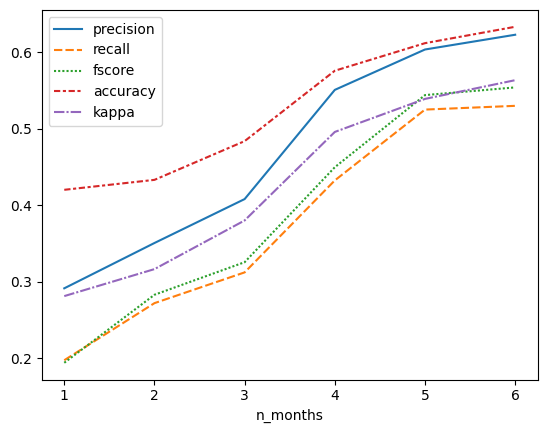

In [18]:
sns.lineplot(data=rf_test_scores)

In [23]:
rf_best_models_hyperparams = get_best_models_hyperparams(rf_results, rf_hyperparameters)
rf_best_models_hyperparams

n_months  n_estimators  max_depth
0         1           120         10
1         2           190         16
2         3           380         19
3         4           450         17
4         5           380         19
5         6           380         19

In [24]:
rf_cross_val_scores = get_cross_val_scores(rf_results)
rf_cross_val_scores.head()

n_months  mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         1       7.370475      0.009758         0.203622        0.002576   
1         1      27.915622      0.916207         0.371727        0.042255   
2         1      20.327585      1.269749         0.368862        0.044080   
3         1      33.415080      1.393729         0.403189        0.004466   
4         1      10.554142      0.855736         0.289420        0.005627   

  param_n_estimators param_max_depth                                  params  \
0                210               4   {'n_estimators': 210, 'max_depth': 4}   
1                280              19  {'n_estimators': 280, 'max_depth': 19}   
2                320               7   {'n_estimators': 320, 'max_depth': 7}   
3                390              14  {'n_estimators': 390, 'max_depth': 14}   
4                400               3   {'n_estimators': 400, 'max_depth': 3}   

   split0_test_accuracy  split1_test_accuracy  ...  split2_test_fscore  \
0              0.413681              0.405945  ...            0.322079   
1              0.422638              0.436889  ...            0.401712   
2              0.423453              0.425081  ...            0.373214   
3              0.419788              0.440147  ...            0.403005   
4              0.410016              0.378257  ...            0.309574   

   mean_test_fscore  std_test_fscore  rank_test_fscore  split0_test_kappa  \
0          0.328246         0.015061                94           0.241618   
1          0.403344         0.015289                 2           0.293189   
2          0.375514         0.011742                77           0.279759   
3          0.402490         0.017026                 4           0.289288   
4          0.301701         0.006583                97           0.228627   

   split1_test_kappa  split2_test_kappa  mean_test_kappa  std_test_kappa  \
0           0.260971           0.258536         0.253708        0.008607   
1           0.318691           0.298438         0.303439        0.010995   
2           0.297248           0.287861         0.288289        0.007146   
3           0.321766           0.304233         0.305096        0.013273   
4           0.215265           0.245567         0.229820        0.012399   

   rank_test_kappa  
0               93  
1                7  
2               74  
3                1  
4               97  

[5 rows x 38 columns]

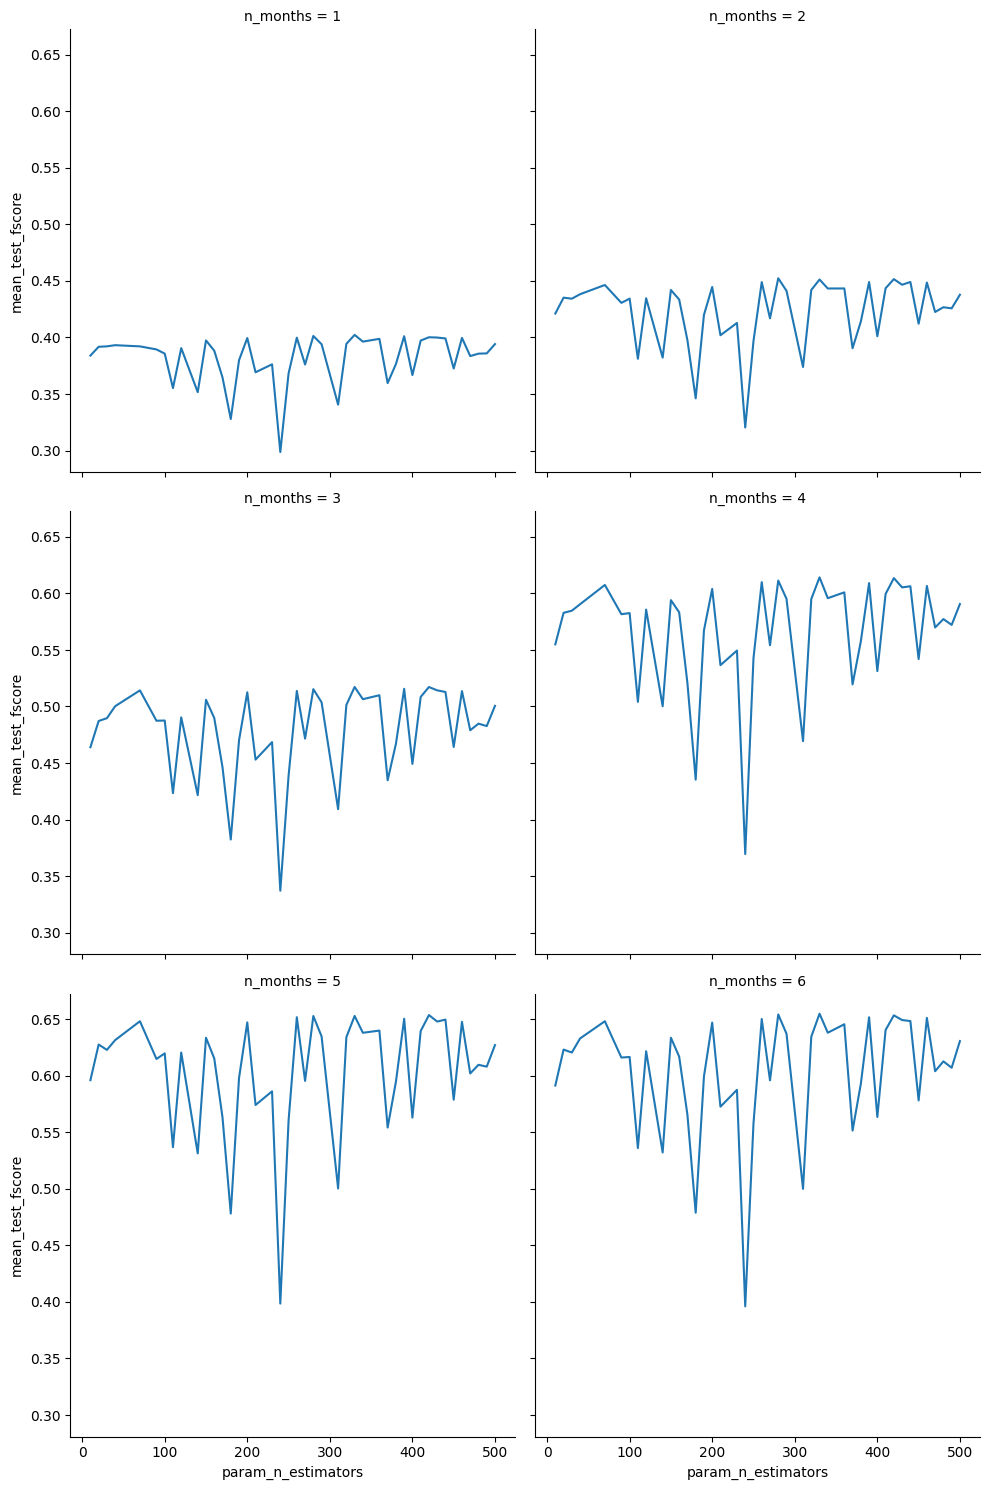

In [107]:
plot_cross_val_scores(rf_cross_val_scores, "n_estimators", "fscore")

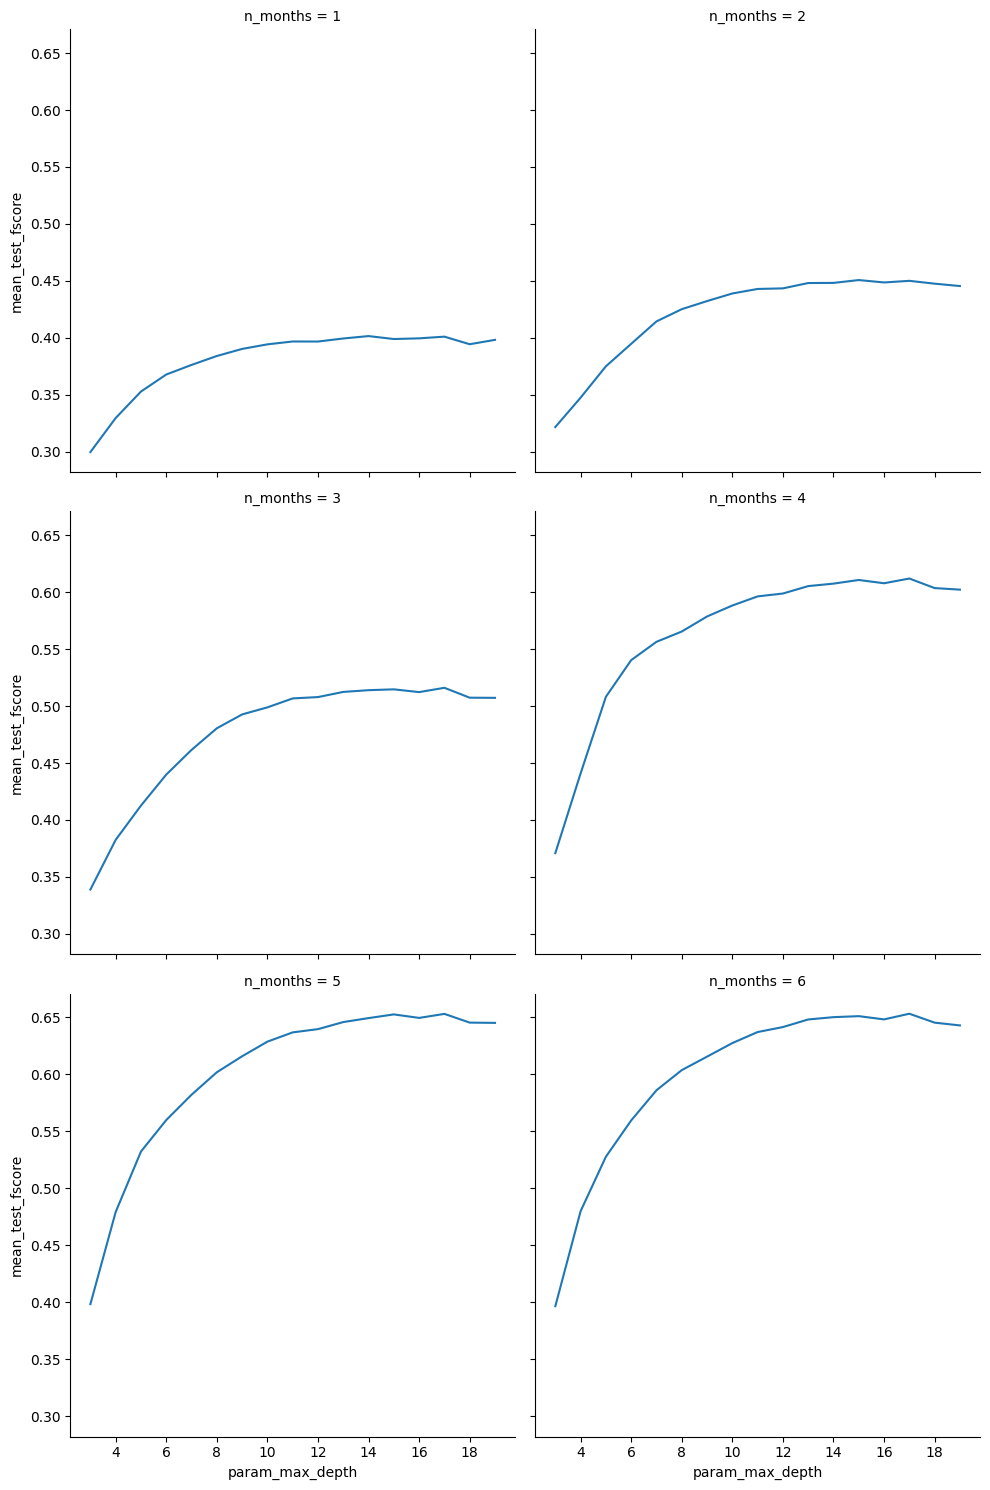

In [25]:
plot_cross_val_scores(rf_cross_val_scores, "max_depth", "fscore")

### LightGBM

In [19]:
with open(dumps_path / "lgbm_results.dump", "rb") as f:
    lgbm_results = pickle.load(f)

In [20]:
lgbm_test_scores = get_test_scores(lgbm_results)
lgbm_test_scores

precision  recall  fscore  accuracy  kappa
n_months                                            
1              0.29    0.24    0.24      0.43   0.31
2              0.37    0.26    0.27      0.44   0.33
3              0.43    0.35    0.36      0.51   0.41
4              0.58    0.47    0.50      0.61   0.54
5              0.65    0.56    0.58      0.66   0.59
6              0.70    0.58    0.61      0.67   0.61

<AxesSubplot: xlabel='n_months'>

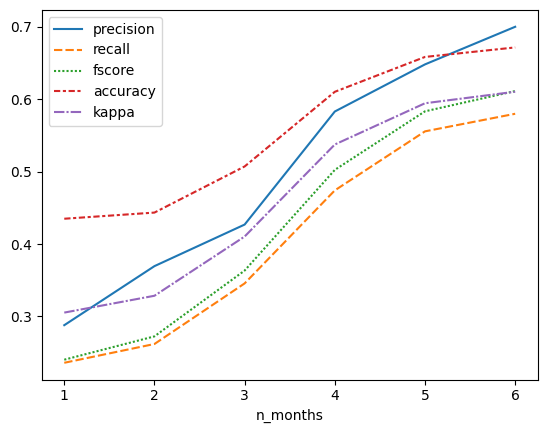

In [15]:
sns.lineplot(data=lgbm_test_scores)

In [16]:
lgbm_best_models_hyperparams = get_best_models_hyperparams(lgbm_results, lgbm_hyperparameters)
lgbm_best_models_hyperparams

n_months boosting_type  n_estimators  max_depth  learning_rate
0         1          dart           180          6            0.1
1         2          dart           490          9            0.1
2         3          dart           490          9            0.1
3         4          dart           490          9            0.1
4         5          dart           490          9            0.1
5         6          dart           490          9            0.1

In [17]:
lgbm_cross_val_scores = get_cross_val_scores(lgbm_results)
lgbm_cross_val_scores.head()

n_months  mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         1      62.565919      0.702547         1.631035        0.308468   
1         1      97.275526      2.611655         2.399570        0.245901   
2         1      41.534364      0.769820         0.892457        0.044860   
3         1      83.167441      0.415336         2.379344        0.237520   
4         1     132.289003      0.249212         2.988849        0.133982   

  param_n_estimators param_max_depth param_learning_rate param_boosting_type  \
0                160               9                0.01                dart   
1                250               8                0.01                dart   
2                160               5               0.001                dart   
3                290               5                0.01                dart   
4                340               7               0.001                dart   

                                              params  ...  split2_test_fscore  \
0  {'n_estimators': 160, 'max_depth': 9, 'learnin...  ...            0.391067   
1  {'n_estimators': 250, 'max_depth': 8, 'learnin...  ...            0.396137   
2  {'n_estimators': 160, 'max_depth': 5, 'learnin...  ...            0.166333   
3  {'n_estimators': 290, 'max_depth': 5, 'learnin...  ...            0.399947   
4  {'n_estimators': 340, 'max_depth': 7, 'learnin...  ...            0.297015   

   mean_test_fscore  std_test_fscore  rank_test_fscore  split0_test_kappa  \
0          0.391045         0.018023                25           0.278941   
1          0.395851         0.011406                19           0.288831   
2          0.157786         0.006055                43           0.004429   
3          0.394347         0.013081                22           0.287261   
4          0.292511         0.013849                34           0.160921   

   split1_test_kappa  split2_test_kappa  mean_test_kappa  std_test_kappa  \
0           0.310198           0.292588         0.293909        0.012795   
1           0.305718           0.294205         0.296251        0.007044   
2           0.003623           0.015651         0.007901        0.005490   
3           0.305671           0.308669         0.300533        0.009464   
4           0.206313           0.202825         0.190019        0.020625   

   rank_test_kappa  
0               25  
1               22  
2               43  
3               16  
4               35  

[5 rows x 40 columns]

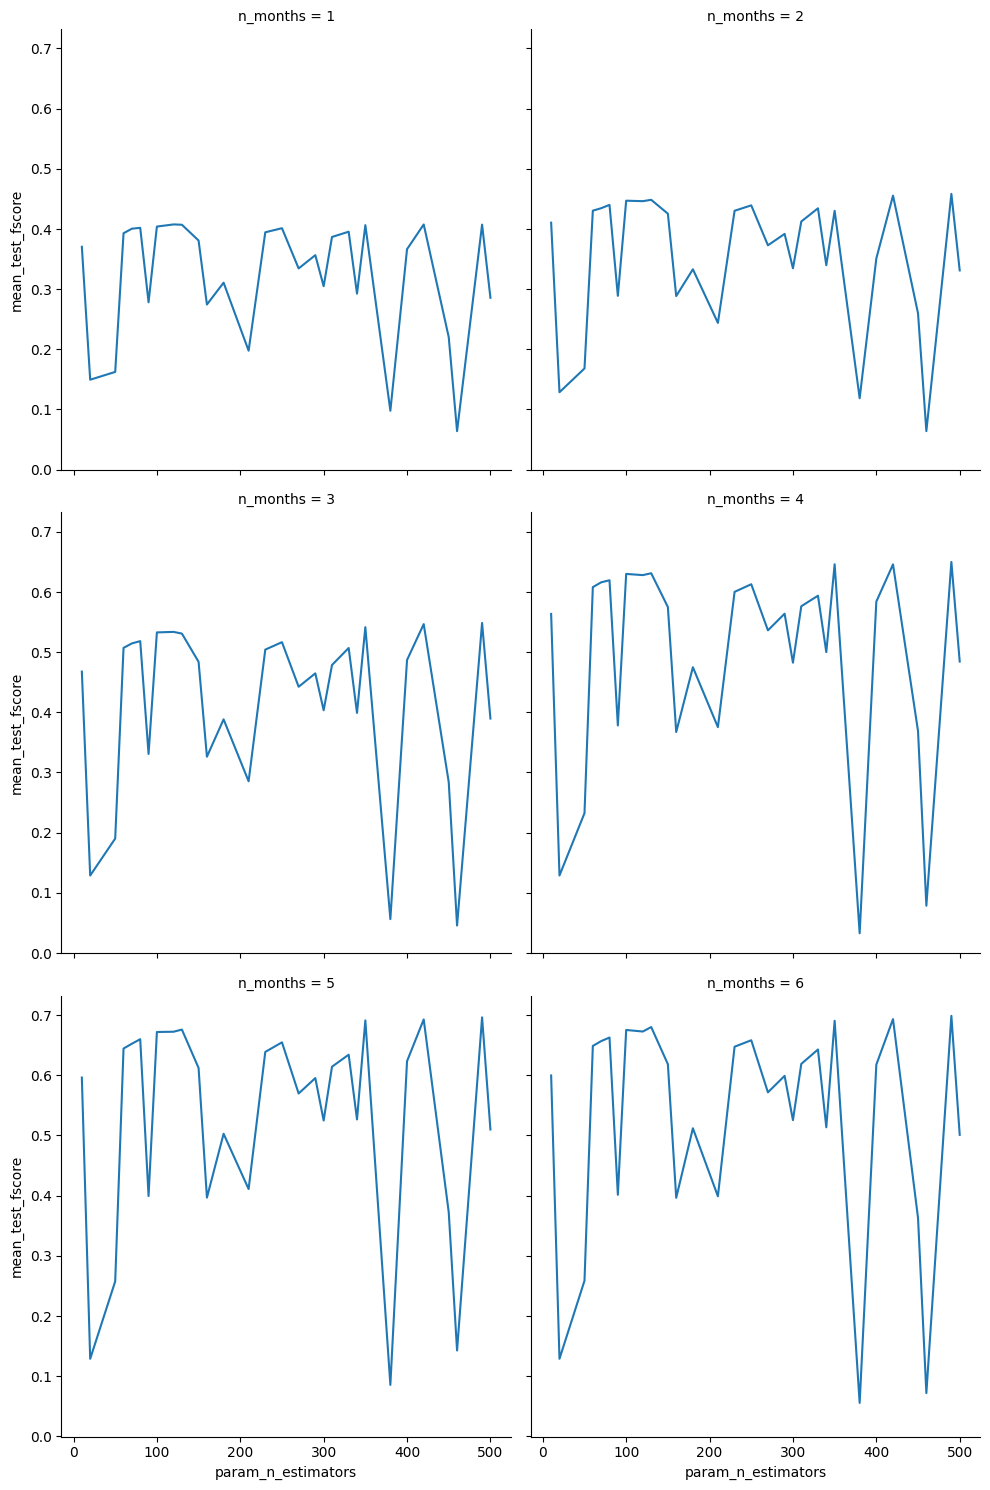

In [18]:
plot_cross_val_scores(lgbm_cross_val_scores, "n_estimators", "fscore")

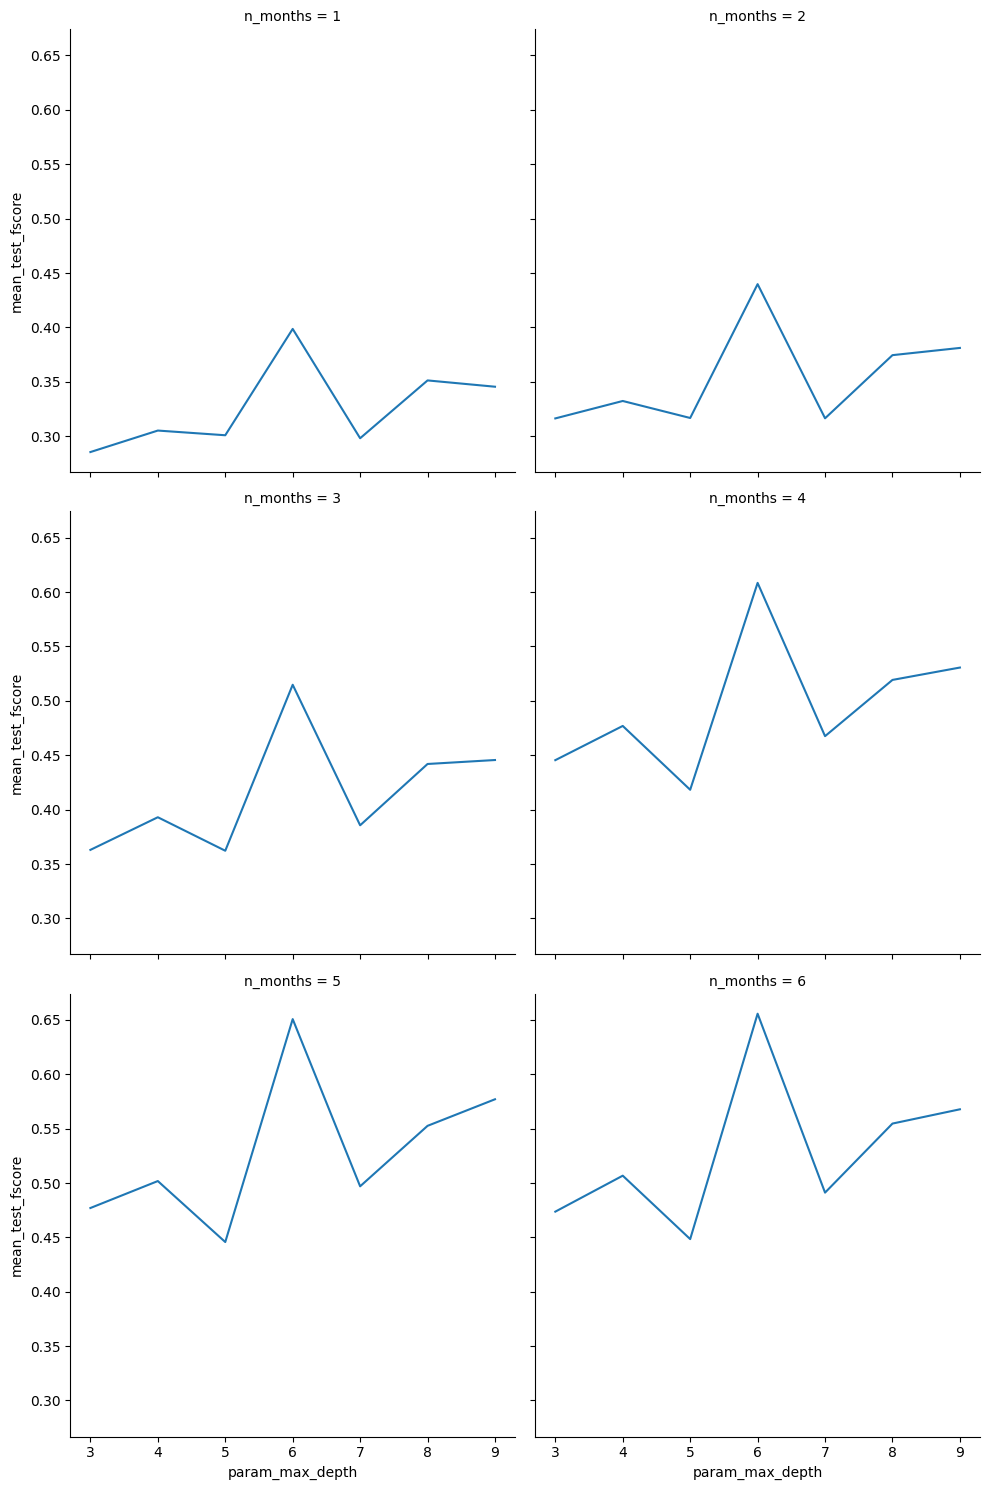

In [19]:
plot_cross_val_scores(lgbm_cross_val_scores, "max_depth", "fscore")

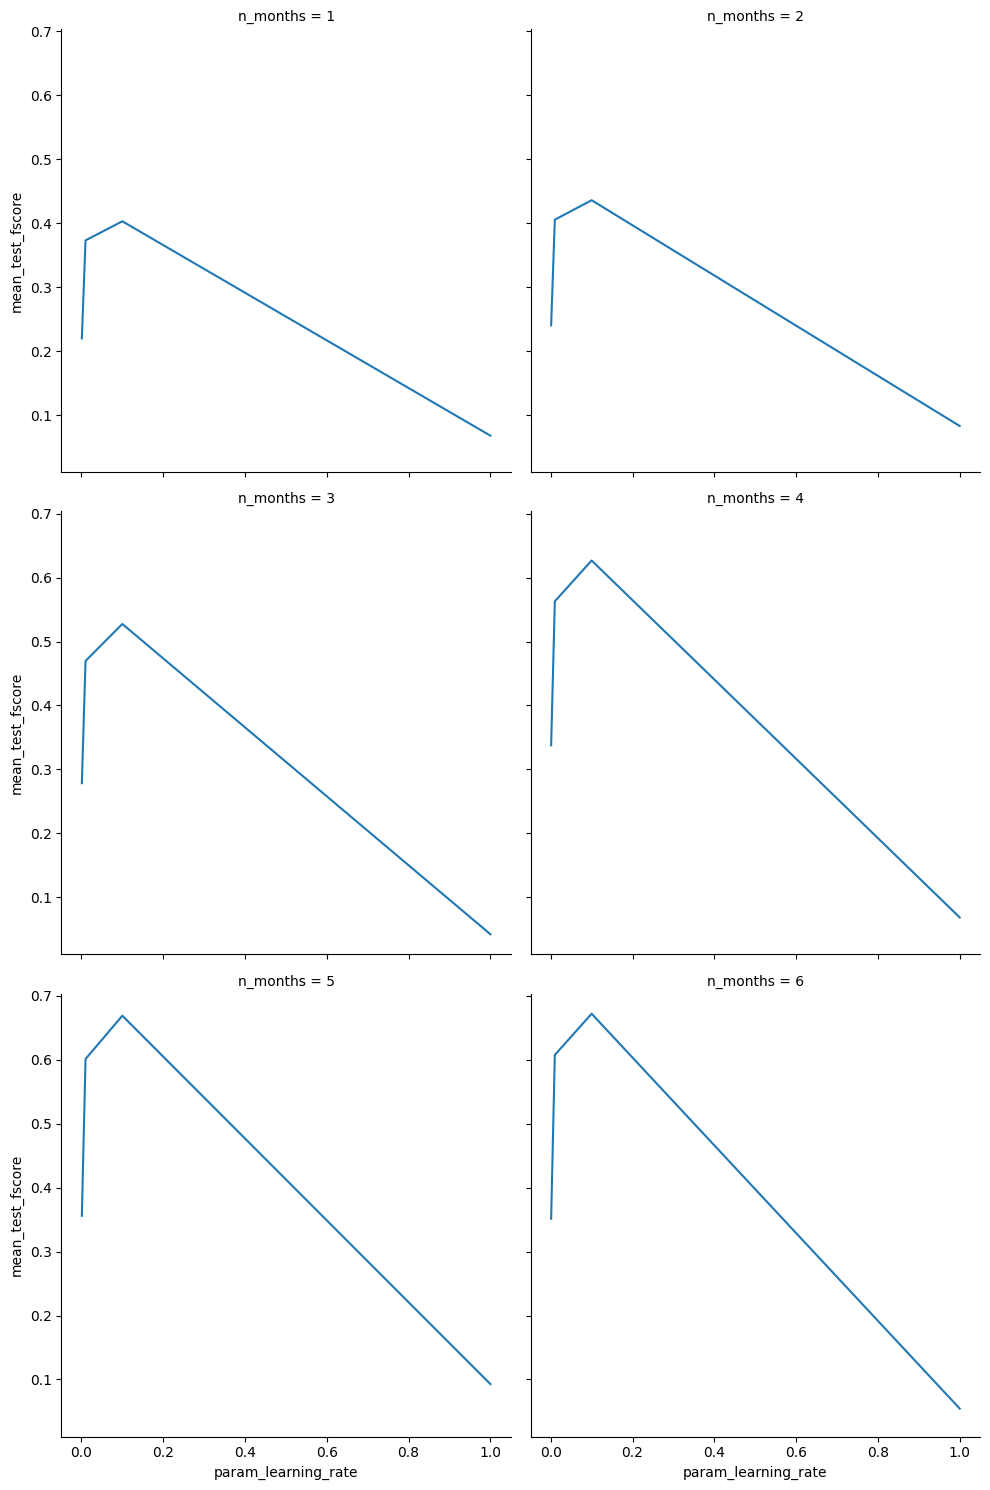

In [20]:
plot_cross_val_scores(lgbm_cross_val_scores, "learning_rate", "fscore")

### Catboost

In [21]:
with open(dumps_path / "catboost_results.dump", "rb") as f:
    catboost_results = pickle.load(f)

In [22]:
catboost_test_scores = get_test_scores(catboost_results)
catboost_test_scores

precision  recall  fscore  accuracy  kappa
n_months                                            
1              0.25    0.21    0.21      0.42   0.29
2              0.33    0.27    0.28      0.42   0.31
3              0.39    0.33    0.35      0.48   0.38
4              0.54    0.45    0.47      0.58   0.50
5              0.61    0.52    0.55      0.62   0.55
6              0.61    0.54    0.56      0.63   0.56

<AxesSubplot: xlabel='n_months'>

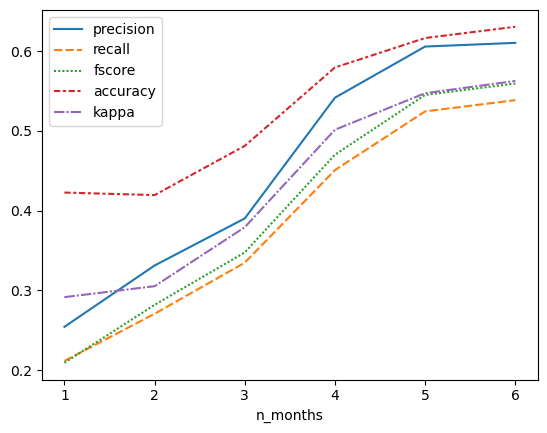

In [14]:
sns.lineplot(data=catboost_test_scores)

In [20]:
catboost_results

defaultdict(dict, {1: {}, 2: {}})

In [22]:
catboost_best_models_hyperparams = get_best_models_hyperparams(catboost_results, catboost_hyperparameters)
catboost_best_models_hyperparams

n_months  iterations  depth
0         1         190      3
1         2         190      4
2         3         170      3
3         4         190      4
4         5         190      6
5         6         190      4

In [23]:
catboost_cross_val_scores = get_cross_val_scores(catboost_results)
catboost_cross_val_scores.head()

n_months  mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         1      14.257454      0.243732         0.112536        0.003629   
1         1       9.723388      0.174220         0.109062        0.001629   
2         1       9.070178      0.214100         0.110162        0.001703   
3         1      17.952922      0.137951         0.119128        0.019834   
4         1       4.571381      0.328386         0.122917        0.019214   

  param_iterations param_depth                           params  \
0              190           4  {'iterations': 190, 'depth': 4}   
1              130           4  {'iterations': 130, 'depth': 4}   
2              110           4  {'iterations': 110, 'depth': 4}   
3              130           5  {'iterations': 130, 'depth': 5}   
4               90           3   {'iterations': 90, 'depth': 3}   

   split0_test_accuracy  split1_test_accuracy  ...  split2_test_fscore  \
0              0.410831              0.430782  ...            0.399387   
1              0.413274              0.432410  ...            0.393782   
2              0.409609              0.424267  ...            0.385547   
3              0.403909              0.422231  ...            0.389724   
4              0.405945              0.404316  ...            0.384209   

   mean_test_fscore  std_test_fscore  rank_test_fscore  split0_test_kappa  \
0          0.398672         0.015736                 4           0.282726   
1          0.398123         0.017091                 5           0.284473   
2          0.393323         0.015813                11           0.279838   
3          0.392328         0.018132                13           0.274147   
4          0.380088         0.008498                19           0.271248   

   split1_test_kappa  split2_test_kappa  mean_test_kappa  std_test_kappa  \
0           0.311728           0.286683         0.293712        0.012841   
1           0.316096           0.283123         0.294564        0.015236   
2           0.307382           0.273284         0.286835        0.014774   
3           0.305629           0.275910         0.285229        0.014443   
4           0.278788           0.273494         0.274510        0.003161   

   rank_test_kappa  
0                5  
1                4  
2               11  
3               12  
4               18  

[5 rows x 38 columns]

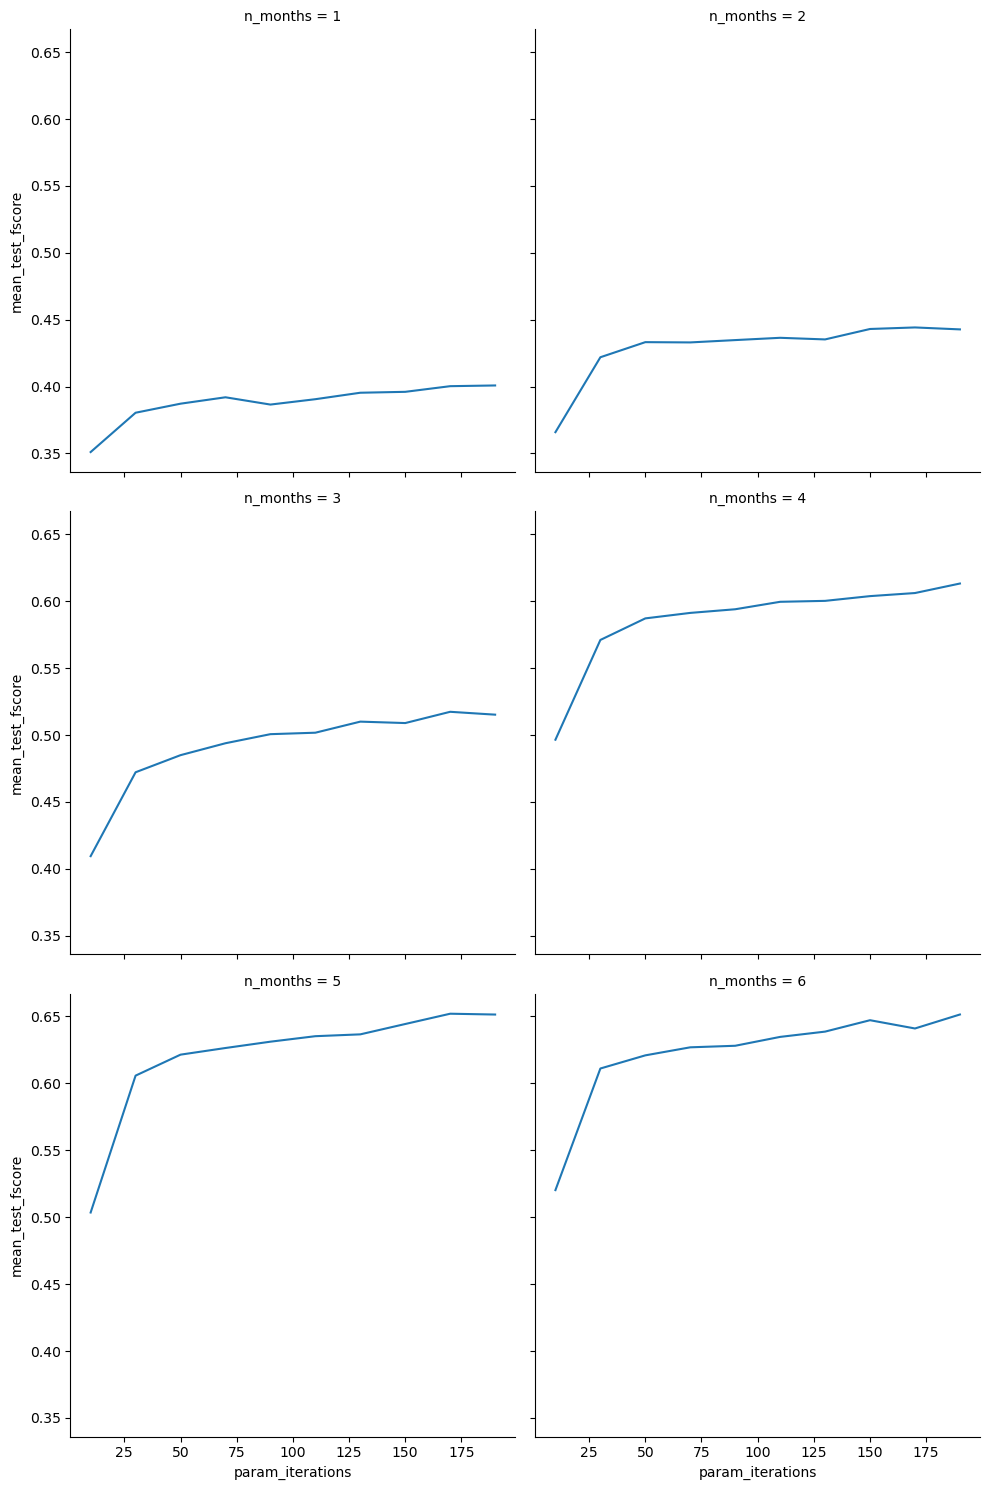

In [24]:
plot_cross_val_scores(catboost_cross_val_scores, "iterations", "fscore")

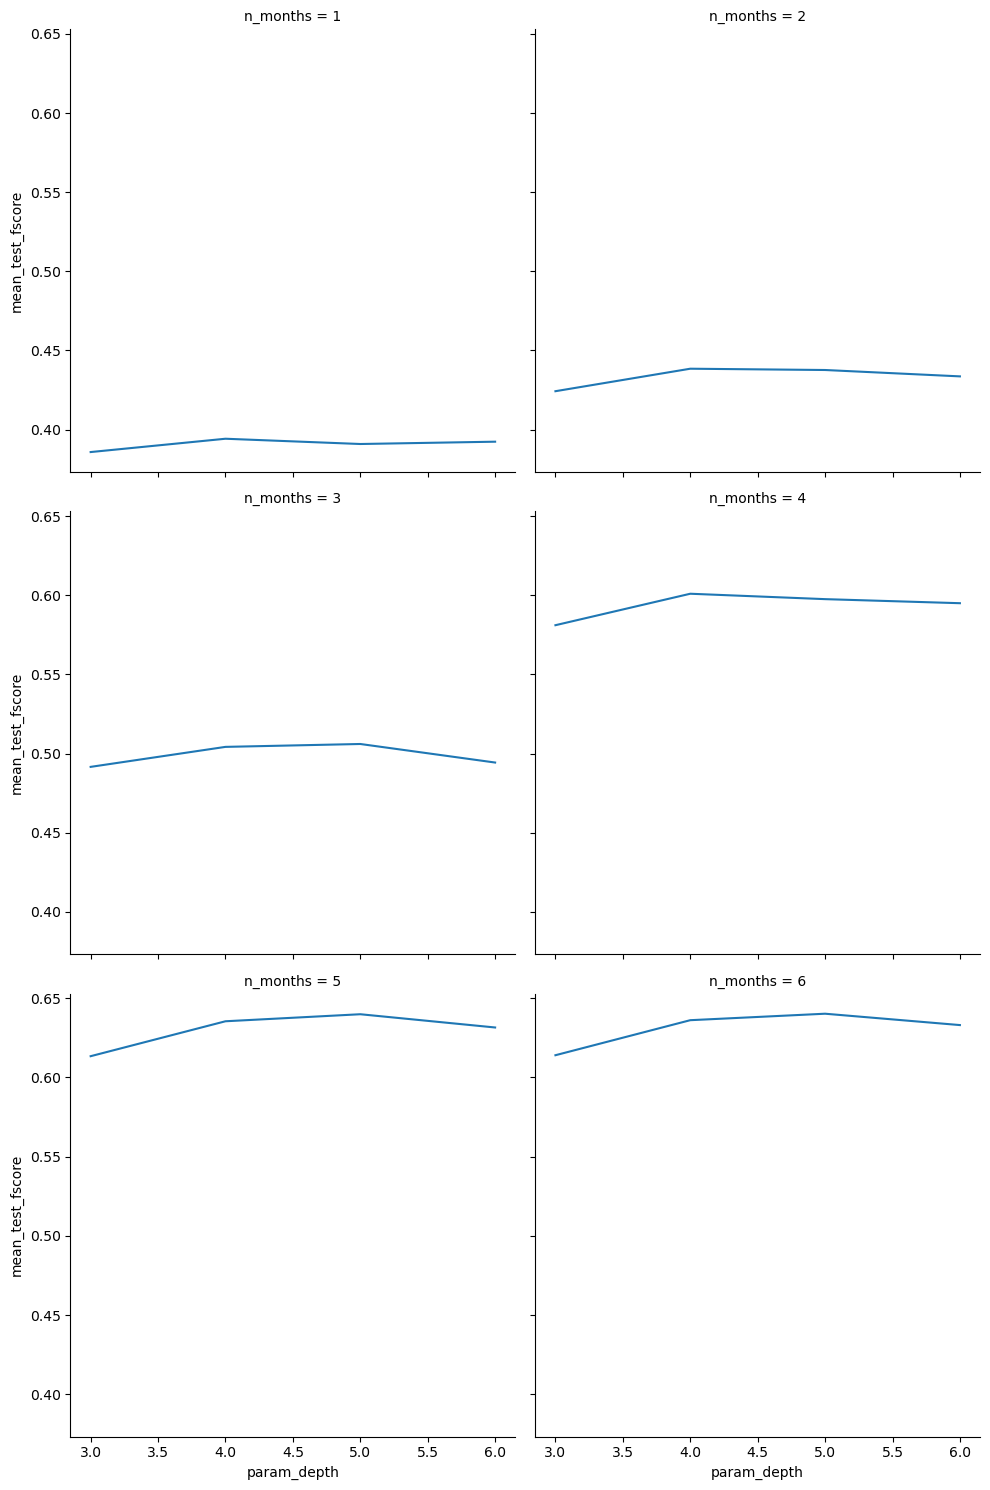

In [25]:
plot_cross_val_scores(catboost_cross_val_scores, "depth", "fscore")

### Transformer

In [23]:
with open(dumps_path / "transformer_results.dump", "rb") as f:
    transformer_results = pickle.load(f)

In [24]:
transformer_stats = get_nn_stats(transformer_results)
transformer_stats

n_months  epoch  trainloss  testloss  accuracy  precision  recall  fscore  \
0          1      1       2.16      2.16      0.33       0.08    0.13    0.08   
1          1      2       1.83      1.96      0.40       0.14    0.17    0.13   
2          1      3       1.73      1.97      0.35       0.10    0.13    0.11   
3          1      4       1.70      1.87      0.39       0.12    0.16    0.13   
4          1      5       1.66      1.89      0.39       0.13    0.17    0.14   
..       ...    ...        ...       ...       ...        ...     ...     ...   
45         6     46       0.63      1.21      0.66       0.56    0.64    0.58   
46         6     47       0.64      1.20      0.65       0.59    0.62    0.58   
47         6     48       0.63      1.19      0.64       0.57    0.63    0.58   
48         6     49       0.63      1.16      0.67       0.62    0.65    0.62   
49         6     50       0.62      1.22      0.66       0.60    0.63    0.60   

    kappa  earliness  classification_loss  earliness_reward  
0    0.18        0.0                 2.16               0.0  
1    0.26        0.0                 1.96               0.0  
2    0.20        0.0                 1.97               0.0  
3    0.24        0.0                 1.87               0.0  
4    0.25        0.0                 1.89               0.0  
..    ...        ...                  ...               ...  
45   0.61        0.0                 1.21               0.0  
46   0.58        0.0                 1.20               0.0  
47   0.58        0.0                 1.19               0.0  
48   0.61        0.0                 1.16               0.0  
49   0.60        0.0                 1.22               0.0  

[300 rows x 12 columns]

In [25]:
transformer_test_scores = get_nn_test_scores(transformer_results)
transformer_test_scores

accuracy  precision  recall  fscore  kappa
n_months                                            
1             0.43       0.23    0.20    0.18   0.30
2             0.44       0.33    0.32    0.29   0.33
3             0.55       0.48    0.42    0.41   0.46
4             0.64       0.55    0.56    0.54   0.57
5             0.67       0.69    0.65    0.64   0.62
6             0.68       0.66    0.65    0.63   0.63

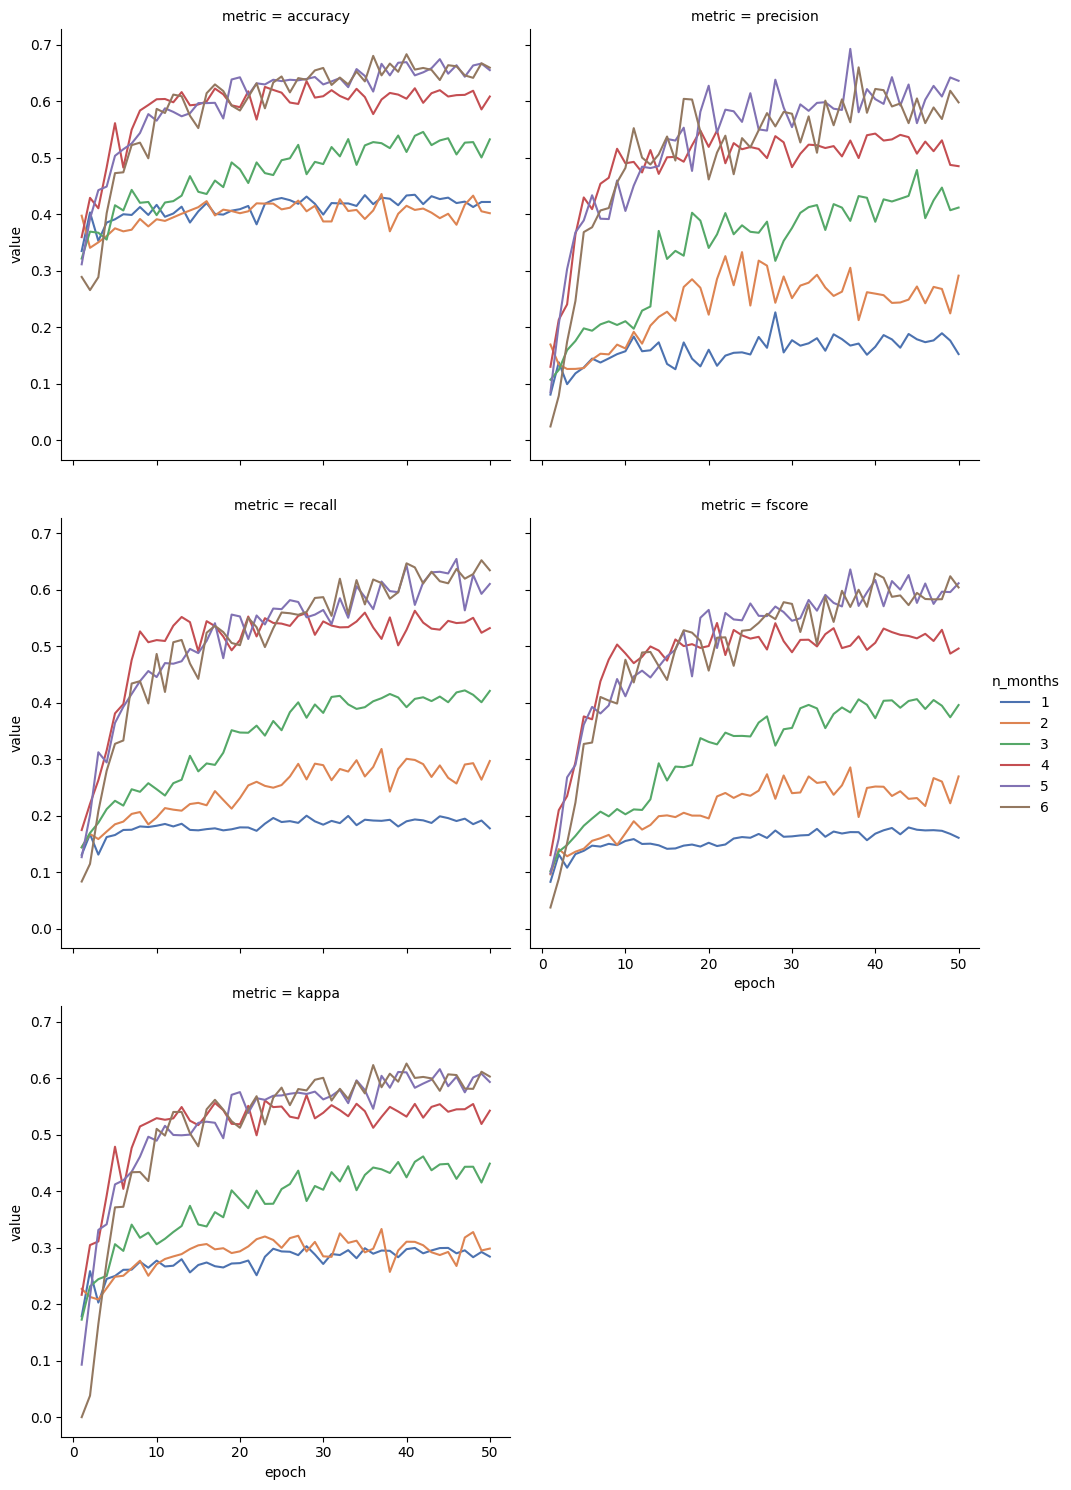

In [35]:
plot_nn_learning_curves(transformer_stats)

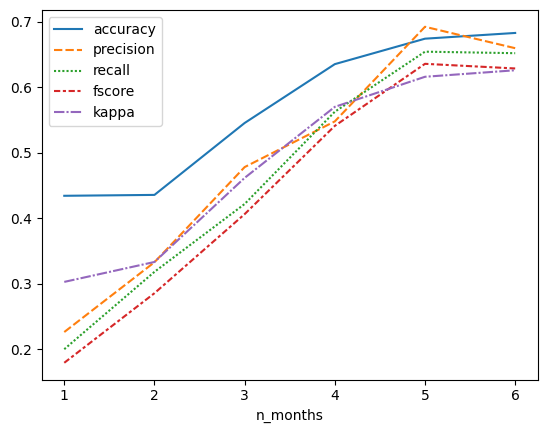

In [62]:
plot_nn_monthly_scores(transformer_stats)

### TempCNN

In [26]:
with open(dumps_path / "tempcnn_results.dump", "rb") as f:
    tempcnn_results = pickle.load(f)

In [27]:
tempcnn_stats = get_nn_stats(tempcnn_results)
tempcnn_stats

n_months  epoch  trainloss  testloss  accuracy  precision  recall  fscore  \
0          1      1       1.78      1.89      0.37       0.13    0.15    0.12   
1          1      2       1.64      1.95      0.39       0.14    0.15    0.11   
2          1      3       1.58      1.70      0.43       0.16    0.19    0.16   
3          1      4       1.54      1.91      0.39       0.19    0.16    0.13   
4          1      5       1.51      2.05      0.32       0.27    0.18    0.12   
..       ...    ...        ...       ...       ...        ...     ...     ...   
35         6     36       0.19      1.79      0.66       0.64    0.64    0.63   
36         6     37       0.19      2.34      0.57       0.56    0.55    0.53   
37         6     38       0.19      3.26      0.54       0.53    0.54    0.49   
38         6     39       0.17      1.90      0.62       0.62    0.57    0.58   
39         6     40       0.17      1.97      0.67       0.66    0.64    0.64   

    kappa  earliness  classification_loss  earliness_reward  
0    0.23        0.0                 1.89               0.0  
1    0.24        0.0                 1.95               0.0  
2    0.30        0.0                 1.70               0.0  
3    0.25        0.0                 1.91               0.0  
4    0.20        0.0                 2.05               0.0  
..    ...        ...                  ...               ...  
35   0.60        0.0                 1.79               0.0  
36   0.51        0.0                 2.34               0.0  
37   0.47        0.0                 3.26               0.0  
38   0.55        0.0                 1.90               0.0  
39   0.62        0.0                 1.97               0.0  

[249 rows x 12 columns]

In [28]:
tempcnn_test_scores = get_nn_test_scores(tempcnn_results)
tempcnn_test_scores

accuracy  precision  recall  fscore  kappa
n_months                                            
1             0.48       0.36    0.28    0.27   0.37
2             0.48       0.41    0.34    0.33   0.37
3             0.56       0.53    0.46    0.46   0.48
4             0.65       0.68    0.60    0.60   0.59
5             0.69       0.70    0.69    0.68   0.64
6             0.70       0.69    0.67    0.64   0.65

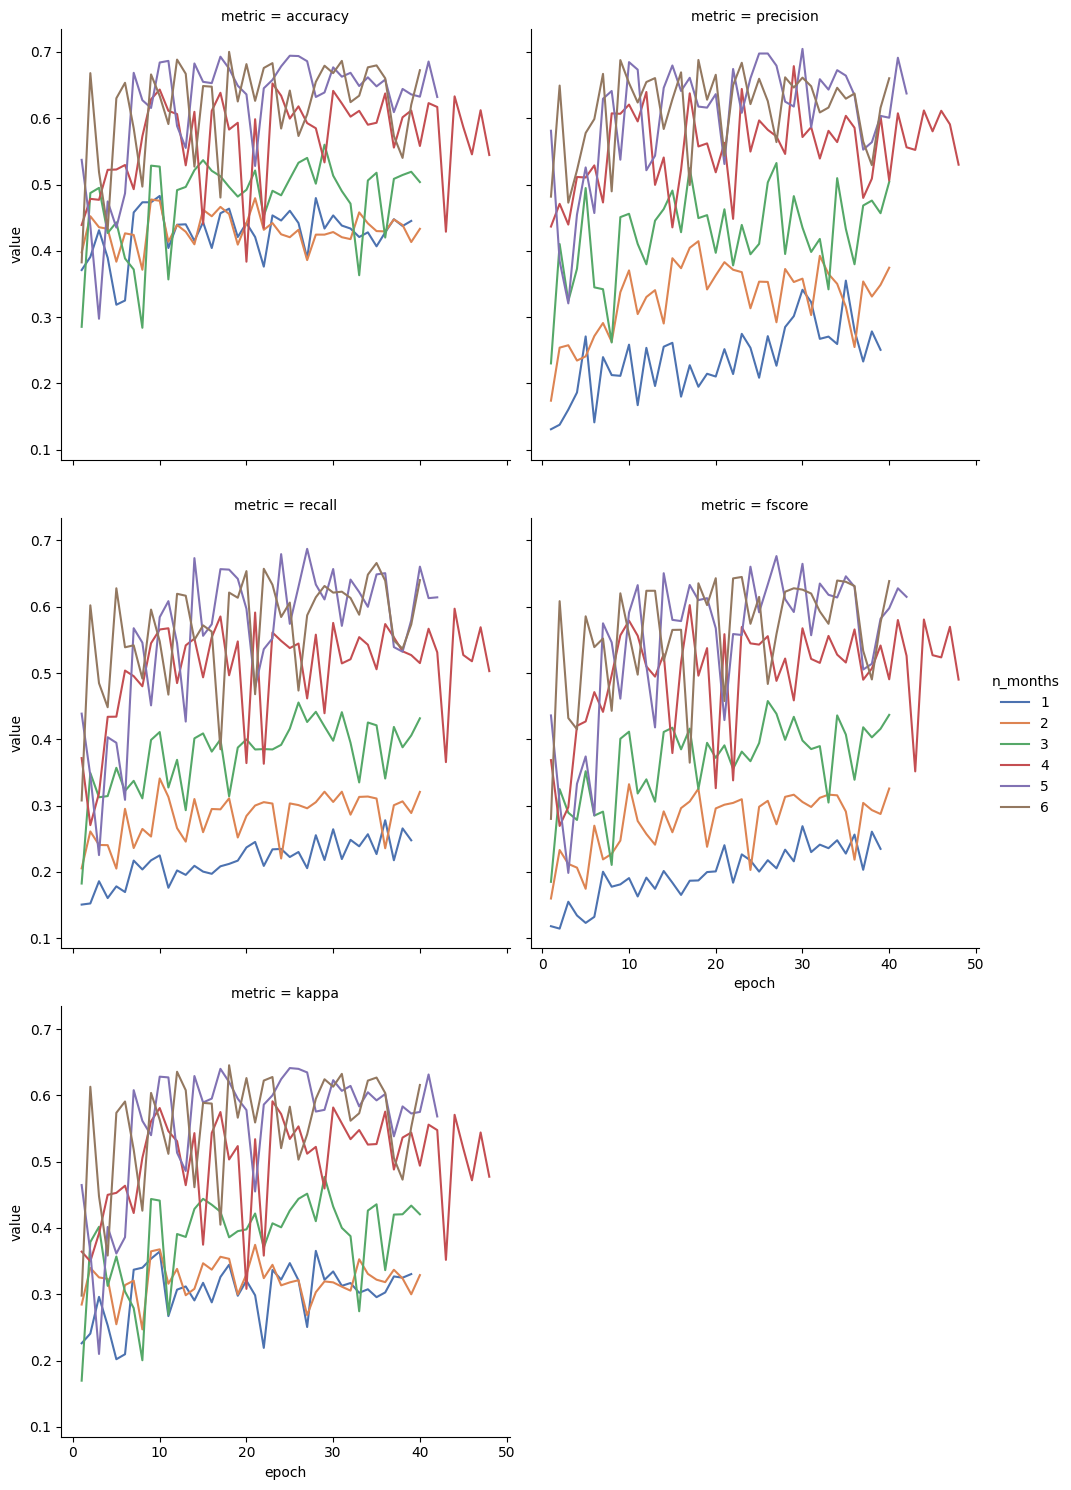

In [49]:
plot_nn_learning_curves(tempcnn_stats)

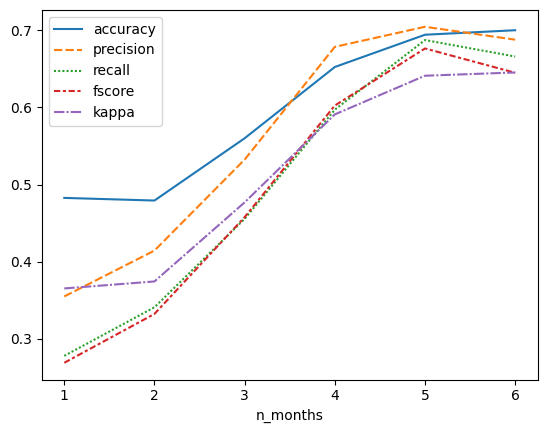

In [64]:
plot_nn_monthly_scores(tempcnn_stats)

### EarlyRNN

In [29]:
with open(dumps_path / "earlyrnn_results.dump", "rb") as f:
    earlyrnn_results = pickle.load(f)

In [30]:
earlyrnn_stats, earlyrnn_monthly_scores = get_early_nn_stats(earlyrnn_results)
earlyrnn_stats

epoch  trainloss  testloss  accuracy  precision  recall  fscore  kappa  \
0       1      10.02      9.65      0.39       0.08    0.14    0.10   0.22   
1       2       8.85      9.31      0.40       0.19    0.17    0.12   0.25   
2       3       8.64      8.76      0.43       0.17    0.18    0.14   0.27   
3       4       7.98      8.80      0.45       0.25    0.25    0.23   0.32   
4       5       7.52      8.91      0.45       0.20    0.22    0.19   0.33   
5       6       6.97      8.53      0.49       0.38    0.29    0.28   0.39   
6       7       6.53      7.90      0.50       0.40    0.27    0.26   0.40   
7       8       6.02      7.37      0.57       0.38    0.35    0.34   0.48   
8       9       5.67      7.61      0.58       0.49    0.43    0.44   0.51   
9      10       5.34      7.10      0.61       0.51    0.48    0.48   0.53   
10     11       5.17      7.51      0.62       0.56    0.48    0.50   0.55   
11     12       5.02      7.65      0.61       0.53    0.42    0.43   0.54   
12     13       4.79      6.73      0.66       0.59    0.57    0.57   0.60   
13     14       4.63      6.92      0.63       0.59    0.53    0.54   0.56   
14     15       4.79      7.12      0.65       0.56    0.53    0.54   0.58   
15     16       4.50      7.19      0.65       0.59    0.53    0.55   0.59   
16     17       4.36      6.69      0.67       0.62    0.57    0.59   0.61   
17     18       4.29      7.12      0.64       0.57    0.55    0.55   0.58   
18     19       4.21      6.84      0.66       0.63    0.54    0.57   0.60   
19     20       4.12      6.75      0.67       0.63    0.55    0.57   0.60   
20     21       3.98      6.94      0.66       0.59    0.58    0.58   0.60   
21     22       3.78      7.03      0.69       0.63    0.60    0.60   0.63   
22     23       3.86      7.05      0.68       0.63    0.59    0.60   0.62   
23     24       3.86      7.19      0.67       0.62    0.58    0.59   0.61   
24     25       3.67      7.53      0.65       0.64    0.55    0.57   0.58   
25     26       3.82      6.71      0.68       0.60    0.60    0.60   0.62   
26     27       3.70      7.07      0.69       0.66    0.58    0.60   0.63   
27     28       3.59      7.24      0.68       0.65    0.58    0.60   0.62   
28     29       3.58      6.86      0.68       0.63    0.57    0.59   0.62   
29     30       3.59      7.23      0.66       0.59    0.60    0.59   0.61   
30     31       3.41      7.27      0.66       0.63    0.57    0.58   0.60   
31     32       3.49      7.08      0.67       0.63    0.57    0.59   0.61   
32     33       3.38      7.04      0.69       0.63    0.62    0.62   0.63   
33     34       3.27      7.20      0.68       0.64    0.56    0.58   0.62   
34     35       3.46      7.03      0.69       0.64    0.60    0.61   0.64   
35     36       3.19      7.75      0.63       0.58    0.53    0.51   0.56   
36     37       3.18      7.15      0.69       0.62    0.62    0.62   0.63   
37     38       3.11      7.59      0.68       0.65    0.56    0.57   0.62   
38     39       3.06      6.97      0.68       0.65    0.59    0.61   0.63   
39     40       3.04      7.02      0.66       0.61    0.61    0.60   0.60   
40     41       3.02      7.77      0.69       0.66    0.63    0.64   0.64   
41     42       3.04      7.46      0.68       0.67    0.57    0.60   0.62   
42     43       3.01      7.10      0.69       0.65    0.61    0.62   0.63   
43     44       3.03      7.50      0.67       0.62    0.61    0.61   0.62   
44     45       2.87      7.34      0.70       0.66    0.62    0.62   0.64   
45     46       2.82      7.25      0.67       0.62    0.60    0.60   0.61   
46     47       2.86      7.44      0.67       0.61    0.61    0.60   0.61   
47     48       2.82      7.16      0.68       0.65    0.61    0.62   0.62   

    earliness  classification_loss  earliness_reward  avg_t_stop  
0        0.02                20.61              1.31       57.61  
1        0.16                20.04             

In [31]:
earlyrnn_monthly_scores

accuracy  precision  recall  fscore  kappa
n_months                                            
1             0.45       0.32    0.26    0.24   0.33
2             0.50       0.41    0.34    0.34   0.40
3             0.58       0.57    0.48    0.46   0.51
4             0.66       0.62    0.61    0.59   0.60
5             0.70       0.66    0.65    0.64   0.65
6             0.70       0.67    0.65    0.63   0.65

<AxesSubplot: xlabel='epoch', ylabel='value'>

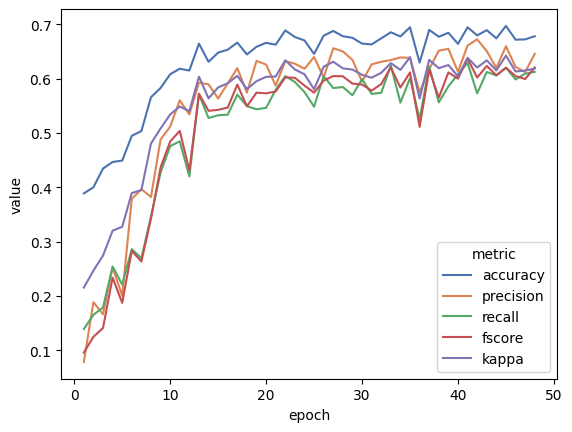

In [57]:
sns.lineplot(
    data=earlyrnn_stats.melt(
        id_vars="epoch",
        value_vars=["accuracy", "precision", "recall", "fscore", "kappa"],
        var_name="metric"
    ),
    x="epoch", y="value", hue="metric",
    palette="deep"
)

<AxesSubplot: xlabel='n_months'>

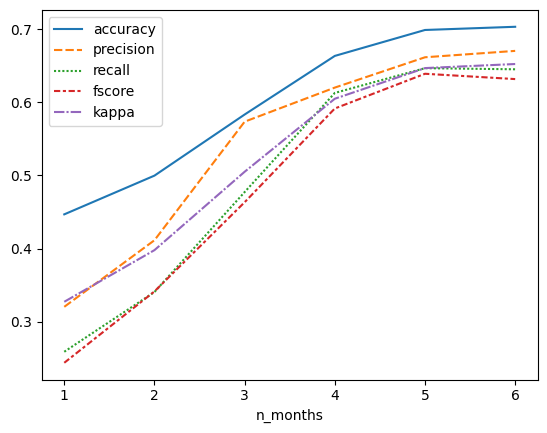

In [58]:
sns.lineplot(data=earlyrnn_monthly_scores)

### EarlyTempCNN

In [32]:
with open(dumps_path / "earlytempcnn_results.dump", "rb") as f:
    earlytempcnn_results = pickle.load(f)

In [33]:
earlytempcnn_stats, earlytempcnn_monthly_scores = get_early_nn_stats(earlytempcnn_results)
earlytempcnn_stats

epoch  trainloss  testloss  accuracy  precision  recall  fscore  kappa  \
0       1       8.49      9.28      0.48       0.34    0.31    0.29   0.39   
1       2       6.51      7.60      0.62       0.51    0.44    0.43   0.55   
2       3       5.79      7.14      0.67       0.55    0.52    0.52   0.61   
3       4       5.38      7.05      0.68       0.60    0.56    0.57   0.62   
4       5       5.10      8.81      0.56       0.48    0.44    0.43   0.49   
5       6       4.94      7.52      0.63       0.57    0.59    0.56   0.57   
6       7       4.80      7.60      0.63       0.58    0.45    0.48   0.55   
7       8       4.73      8.05      0.62       0.63    0.52    0.52   0.55   
8       9       4.52      7.42      0.68       0.62    0.55    0.57   0.61   
9      10       4.45      8.26      0.57       0.49    0.51    0.47   0.50   
10     11       4.38      7.27      0.67       0.60    0.60    0.59   0.62   
11     12       4.39      7.59      0.65       0.61    0.54    0.55   0.59   
12     13       4.25      6.80      0.72       0.70    0.62    0.64   0.67   
13     14       4.22      6.94      0.67       0.64    0.64    0.63   0.62   
14     15       4.12      7.29      0.70       0.65    0.67    0.64   0.64   
15     16       4.10      6.64      0.71       0.70    0.61    0.64   0.66   
16     17       4.03      6.82      0.68       0.69    0.60    0.62   0.62   
17     18       4.02      6.84      0.69       0.66    0.64    0.63   0.63   
18     19       3.95      7.02      0.67       0.64    0.62    0.61   0.61   
19     20       3.89      7.59      0.71       0.59    0.64    0.59   0.66   
20     21       3.87      7.46      0.66       0.63    0.60    0.59   0.60   
21     22       3.86      7.59      0.66       0.66    0.64    0.62   0.61   
22     23       3.82      6.87      0.71       0.69    0.68    0.67   0.66   
23     24       3.77      7.79      0.68       0.67    0.60    0.60   0.62   
24     25       3.73      7.23      0.71       0.70    0.63    0.64   0.66   
25     26       3.72      7.22      0.67       0.65    0.62    0.61   0.61   
26     27       3.69      7.50      0.67       0.65    0.58    0.60   0.61   
27     28       3.63      8.93      0.58       0.66    0.52    0.54   0.52   
28     29       3.62      7.57      0.66       0.62    0.58    0.58   0.60   
29     30       3.66      6.82      0.73       0.71    0.64    0.66   0.67   
30     31       3.57      6.85      0.69       0.59    0.62    0.59   0.63   
31     32       3.54      7.21      0.69       0.68    0.64    0.64   0.64   
32     33       3.53      7.66      0.68       0.67    0.60    0.61   0.63   
33     34       3.52      7.88      0.68       0.65    0.64    0.63   0.62   
34     35       3.48      7.96      0.70       0.72    0.67    0.68   0.65   
35     36       3.52      6.72      0.72       0.67    0.67    0.65   0.67   
36     37       3.45      7.33      0.70       0.68    0.62    0.63   0.65   
37     38       3.46      7.47      0.70       0.66    0.64    0.64   0.64   
38     39       3.42      7.43      0.67       0.62    0.60    0.59   0.61   
39     40       3.40      7.48      0.68       0.68    0.68    0.66   0.62   
40     41       3.39      8.53      0.63       0.66    0.63    0.63   0.57   
41     42       3.37      7.48      0.68       0.67    0.61    0.63   0.62   
42     43       3.38      6.81      0.71       0.69    0.66    0.66   0.66   
43     44       3.30     10.51      0.55       0.60    0.44    0.45   0.48   
44     45       3.28      7.44      0.70       0.73    0.63    0.65   0.64   
45     46       3.29      7.23      0.70       0.68    0.69    0.68   0.65   
46     47       3.27      7.15      0.70       0.64    0.66    0.64   0.65   

    earliness  classification_loss  earliness_reward  avg_t_stop  
0        0.19                20.21              1.65       47.61  
1        0.22                17.10              1.90       46.00  
2        0.25                16.27              1.99      

In [34]:
earlytempcnn_monthly_scores

accuracy  precision  recall  fscore  kappa
n_months                                            
1             0.45       0.35    0.26    0.25   0.33
2             0.50       0.41    0.35    0.34   0.40
3             0.58       0.55    0.48    0.48   0.51
4             0.67       0.65    0.61    0.60   0.61
5             0.72       0.70    0.69    0.66   0.66
6             0.72       0.71    0.68    0.67   0.67

<AxesSubplot: xlabel='epoch', ylabel='value'>

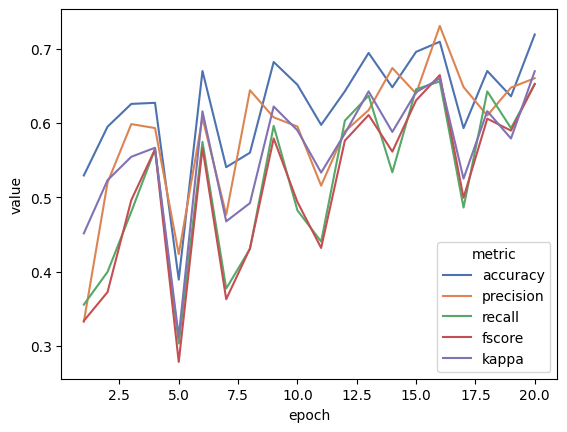

In [14]:
sns.lineplot(
    data=earlytempcnn_stats.melt(
        id_vars="epoch",
        value_vars=["accuracy", "precision", "recall", "fscore", "kappa"],
        var_name="metric"
    ),
    x="epoch", y="value", hue="metric",
    palette="deep"
)

In [53]:
earlyrnn_stats

epoch  trainloss  testloss  accuracy  precision  recall  fscore  kappa  \
0       1      10.02      9.65      0.39       0.08    0.14    0.10   0.22   
1       2       8.85      9.31      0.40       0.19    0.17    0.12   0.25   
2       3       8.64      8.76      0.43       0.17    0.18    0.14   0.27   
3       4       7.98      8.80      0.45       0.25    0.25    0.23   0.32   
4       5       7.52      8.91      0.45       0.20    0.22    0.19   0.33   
5       6       6.97      8.53      0.49       0.38    0.29    0.28   0.39   
6       7       6.53      7.90      0.50       0.40    0.27    0.26   0.40   
7       8       6.02      7.37      0.57       0.38    0.35    0.34   0.48   
8       9       5.67      7.61      0.58       0.49    0.43    0.44   0.51   
9      10       5.34      7.10      0.61       0.51    0.48    0.48   0.53   
10     11       5.17      7.51      0.62       0.56    0.48    0.50   0.55   
11     12       5.02      7.65      0.61       0.53    0.42    0.43   0.54   
12     13       4.79      6.73      0.66       0.59    0.57    0.57   0.60   
13     14       4.63      6.92      0.63       0.59    0.53    0.54   0.56   
14     15       4.79      7.12      0.65       0.56    0.53    0.54   0.58   
15     16       4.50      7.19      0.65       0.59    0.53    0.55   0.59   
16     17       4.36      6.69      0.67       0.62    0.57    0.59   0.61   
17     18       4.29      7.12      0.64       0.57    0.55    0.55   0.58   
18     19       4.21      6.84      0.66       0.63    0.54    0.57   0.60   
19     20       4.12      6.75      0.67       0.63    0.55    0.57   0.60   
20     21       3.98      6.94      0.66       0.59    0.58    0.58   0.60   
21     22       3.78      7.03      0.69       0.63    0.60    0.60   0.63   
22     23       3.86      7.05      0.68       0.63    0.59    0.60   0.62   
23     24       3.86      7.19      0.67       0.62    0.58    0.59   0.61   
24     25       3.67      7.53      0.65       0.64    0.55    0.57   0.58   
25     26       3.82      6.71      0.68       0.60    0.60    0.60   0.62   
26     27       3.70      7.07      0.69       0.66    0.58    0.60   0.63   
27     28       3.59      7.24      0.68       0.65    0.58    0.60   0.62   
28     29       3.58      6.86      0.68       0.63    0.57    0.59   0.62   
29     30       3.59      7.23      0.66       0.59    0.60    0.59   0.61   
30     31       3.41      7.27      0.66       0.63    0.57    0.58   0.60   
31     32       3.49      7.08      0.67       0.63    0.57    0.59   0.61   
32     33       3.38      7.04      0.69       0.63    0.62    0.62   0.63   
33     34       3.27      7.20      0.68       0.64    0.56    0.58   0.62   
34     35       3.46      7.03      0.69       0.64    0.60    0.61   0.64   
35     36       3.19      7.75      0.63       0.58    0.53    0.51   0.56   
36     37       3.18      7.15      0.69       0.62    0.62    0.62   0.63   
37     38       3.11      7.59      0.68       0.65    0.56    0.57   0.62   
38     39       3.06      6.97      0.68       0.65    0.59    0.61   0.63   
39     40       3.04      7.02      0.66       0.61    0.61    0.60   0.60   
40     41       3.02      7.77      0.69       0.66    0.63    0.64   0.64   
41     42       3.04      7.46      0.68       0.67    0.57    0.60   0.62   
42     43       3.01      7.10      0.69       0.65    0.61    0.62   0.63   
43     44       3.03      7.50      0.67       0.62    0.61    0.61   0.62   
44     45       2.87      7.34      0.70       0.66    0.62    0.62   0.64   
45     46       2.82      7.25      0.67       0.62    0.60    0.60   0.61   
46     47       2.86      7.44      0.67       0.61    0.61    0.60   0.61   
47     48       2.82      7.16      0.68       0.65    0.61    0.62   0.62   

    earliness  classification_loss  earliness_reward  avg_t_stop  
0        0.02                20.61              1.31       57.61  
1        0.16                20.04             

In [73]:
early_stats = pd.concat((
    earlyrnn_stats.assign(model="earlyrnn"),
    earlytempcnn_stats.assign(model="earlytempcnn")
)).reset_index(drop=True)
early_stats

epoch  trainloss  testloss  accuracy  precision  recall  fscore  kappa  \
0       1      10.02      9.65      0.39       0.08    0.14    0.10   0.22   
1       2       8.85      9.31      0.40       0.19    0.17    0.12   0.25   
2       3       8.64      8.76      0.43       0.17    0.18    0.14   0.27   
3       4       7.98      8.80      0.45       0.25    0.25    0.23   0.32   
4       5       7.52      8.91      0.45       0.20    0.22    0.19   0.33   
..    ...        ...       ...       ...        ...     ...     ...    ...   
90     43       3.38      6.81      0.71       0.69    0.66    0.66   0.66   
91     44       3.30     10.51      0.55       0.60    0.44    0.45   0.48   
92     45       3.28      7.44      0.70       0.73    0.63    0.65   0.64   
93     46       3.29      7.23      0.70       0.68    0.69    0.68   0.65   
94     47       3.27      7.15      0.70       0.64    0.66    0.64   0.65   

    earliness  classification_loss  earliness_reward  avg_t_stop         model  
0        0.02                20.61              1.31       57.61      earlyrnn  
1        0.16                20.04              1.42       49.42      earlyrnn  
2        0.22                19.03              1.50       46.02      earlyrnn  
3        0.28                19.26              1.65       42.56      earlyrnn  
4        0.28                19.53              1.70       42.30      earlyrnn  
..        ...                  ...               ...         ...           ...  
90       0.39                16.13              2.52       36.10  earlytempcnn  
91       0.31                22.98              1.96       40.59  earlytempcnn  
92       0.38                17.27              2.39       36.71  earlytempcnn  
93       0.36                16.89              2.42       37.48  earlytempcnn  
94       0.33                16.73              2.42       39.48  earlytempcnn  

[95 rows x 13 columns]

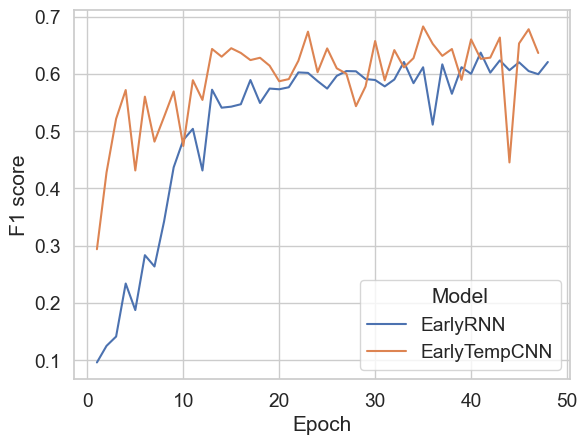

In [74]:
early_fscores = sns.lineplot(data=early_stats, x="epoch", y="fscore", hue="model")
early_fscores.set_xlabel("Epoch")
early_fscores.set_ylabel("F1 score")
early_fscores.legend(title="Model", labels=["EarlyRNN", "EarlyTempCNN"])

In [75]:
early_fscores.figure.savefig("early_fscores.png", dpi=300, bbox_inches="tight")

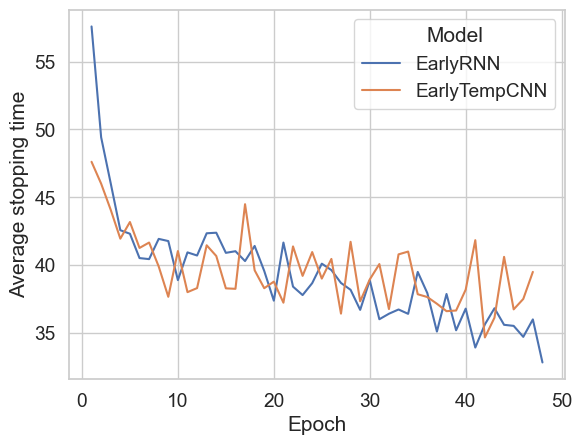

In [76]:
early_stopping_time = sns.lineplot(data=early_stats, x="epoch", y="avg_t_stop", hue="model")
early_stopping_time.set_xlabel("Epoch")
early_stopping_time.set_ylabel("Average stopping time")
early_stopping_time.legend(title="Model", labels=["EarlyRNN", "EarlyTempCNN"])

In [77]:
early_stopping_time.figure.savefig("early_stopping_time.png", dpi=300, bbox_inches="tight")

## Models Comparison

In [35]:
MODELS_LABELS = {
    "rf": "Random Forest",
    "lgbm": "LightGBM",
    "catboost": "CatBoost",
    "transformer": "Transformer",
    "tempcnn": "TempCNN",
    "earlyrnn": "EarlyRNN",
    "earlytempcnn": "EarlyTempCNN"
}

In [36]:
def join_test_scores(test_scores: dict):
    dfs = []
    for model_type, scores in test_scores.items():
        scores = scores.copy()
        scores.insert(0, "model", model_type)
        dfs.append(scores)
    df = pd.concat(dfs)
    df.reset_index(inplace=True)
    
    return df        

In [37]:
joint_test_scores = join_test_scores(
    dict(
        rf=rf_test_scores,
        lgbm=lgbm_test_scores,
        catboost=catboost_test_scores,
        transformer=transformer_test_scores,
        tempcnn=tempcnn_test_scores,
        earlyrnn=earlyrnn_monthly_scores,
        earlytempcnn=earlytempcnn_monthly_scores
    )
)
joint_test_scores

n_months         model  precision  recall  fscore  accuracy  kappa
0          1            rf       0.29    0.20    0.19      0.42   0.28
1          2            rf       0.35    0.27    0.28      0.43   0.32
2          3            rf       0.41    0.31    0.33      0.48   0.38
3          4            rf       0.55    0.43    0.45      0.58   0.50
4          5            rf       0.60    0.52    0.54      0.61   0.54
5          6            rf       0.62    0.53    0.55      0.63   0.56
6          1          lgbm       0.29    0.24    0.24      0.43   0.31
7          2          lgbm       0.37    0.26    0.27      0.44   0.33
8          3          lgbm       0.43    0.35    0.36      0.51   0.41
9          4          lgbm       0.58    0.47    0.50      0.61   0.54
10         5          lgbm       0.65    0.56    0.58      0.66   0.59
11         6          lgbm       0.70    0.58    0.61      0.67   0.61
12         1      catboost       0.25    0.21    0.21      0.42   0.29
13         2      catboost       0.33    0.27    0.28      0.42   0.31
14         3      catboost       0.39    0.33    0.35      0.48   0.38
15         4      catboost       0.54    0.45    0.47      0.58   0.50
16         5      catboost       0.61    0.52    0.55      0.62   0.55
17         6      catboost       0.61    0.54    0.56      0.63   0.56
18         1   transformer       0.23    0.20    0.18      0.43   0.30
19         2   transformer       0.33    0.32    0.29      0.44   0.33
20         3   transformer       0.48    0.42    0.41      0.55   0.46
21         4   transformer       0.55    0.56    0.54      0.64   0.57
22         5   transformer       0.69    0.65    0.64      0.67   0.62
23         6   transformer       0.66    0.65    0.63      0.68   0.63
24         1       tempcnn       0.36    0.28    0.27      0.48   0.37
25         2       tempcnn       0.41    0.34    0.33      0.48   0.37
26         3       tempcnn       0.53    0.46    0.46      0.56   0.48
27         4       tempcnn       0.68    0.60    0.60      0.65   0.59
28         5       tempcnn       0.70    0.69    0.68      0.69   0.64
29         6       tempcnn       0.69    0.67    0.64      0.70   0.65
30         1      earlyrnn       0.32    0.26    0.24      0.45   0.33
31         2      earlyrnn       0.41    0.34    0.34      0.50   0.40
32         3      earlyrnn       0.57    0.48    0.46      0.58   0.51
33         4      earlyrnn       0.62    0.61    0.59      0.66   0.60
34         5      earlyrnn       0.66    0.65    0.64      0.70   0.65
35         6      earlyrnn       0.67    0.65    0.63      0.70   0.65
36         1  earlytempcnn       0.35    0.26    0.25      0.45   0.33
37         2  earlytempcnn       0.41    0.35    0.34      0.50   0.40
38         3  earlytempcnn       0.55    0.48    0.48      0.58   0.51
39         4  earlytempcnn       0.65    0.61    0.60      0.67   0.61
40         5  earlytempcnn       0.70    0.69    0.66      0.72   0.66
41         6  earlytempcnn       0.71    0.68    0.67      0.72   0.67

In [47]:
fscores = joint_test_scores[["n_months", "model", "fscore"]]\
    .pivot(columns="model", index="n_months", values="fscore")
print(fscores.to_latex(caption="F1-Scores of Models Depending on the Number of Months", label="Table 4.1.2"))

\begin{table}
\centering
\caption{F1-Scores of Models Depending on the Number of Months}
\label{Table 4.1.2}
\begin{tabular}{lrrrrrrr}
\toprule
model &  catboost &  earlyrnn &  earlytempcnn &  lgbm &    rf &  tempcnn &  transformer \\
n\_months &           &           &               &       &       &          &              \\
\midrule
1        &      0.21 &      0.24 &          0.25 &  0.24 &  0.19 &     0.27 &         0.18 \\
2        &      0.28 &      0.34 &          0.34 &  0.27 &  0.28 &     0.33 &         0.29 \\
3        &      0.35 &      0.46 &          0.48 &  0.36 &  0.33 &     0.46 &         0.41 \\
4        &      0.47 &      0.59 &          0.60 &  0.50 &  0.45 &     0.60 &         0.54 \\
5        &      0.55 &      0.64 &          0.66 &  0.58 &  0.54 &     0.68 &         0.64 \\
6        &      0.56 &      0.63 &          0.67 &  0.61 &  0.55 &     0.64 &         0.63 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_8143/2025573544.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(fscores.to_latex(caption="F1-Scores of Models Depending on the Number of Months", label="Table 4.1.2"))


In [38]:
metrics_plot_data = joint_test_scores\
    .melt(id_vars=["n_months", "model"], var_name="metric")\
    .transform({
        "n_months": lambda x: x,
        "model": lambda x: MODELS_LABELS[x],
        "metric": lambda x: x.title() if x != "fscore" else "F1 score",
        "value": lambda x: x
    })\
    .rename(columns={
                "n_months": "# of months",
                "model": "Model",
                "metric": "Metric",
                "value": "Metric value"}
           )
metrics_plot_data

# of months          Model     Metric  Metric value
0              1  Random Forest  Precision          0.29
1              2  Random Forest  Precision          0.35
2              3  Random Forest  Precision          0.41
3              4  Random Forest  Precision          0.55
4              5  Random Forest  Precision          0.60
..           ...            ...        ...           ...
205            2   EarlyTempCNN      Kappa          0.40
206            3   EarlyTempCNN      Kappa          0.51
207            4   EarlyTempCNN      Kappa          0.61
208            5   EarlyTempCNN      Kappa          0.66
209            6   EarlyTempCNN      Kappa          0.67

[210 rows x 4 columns]

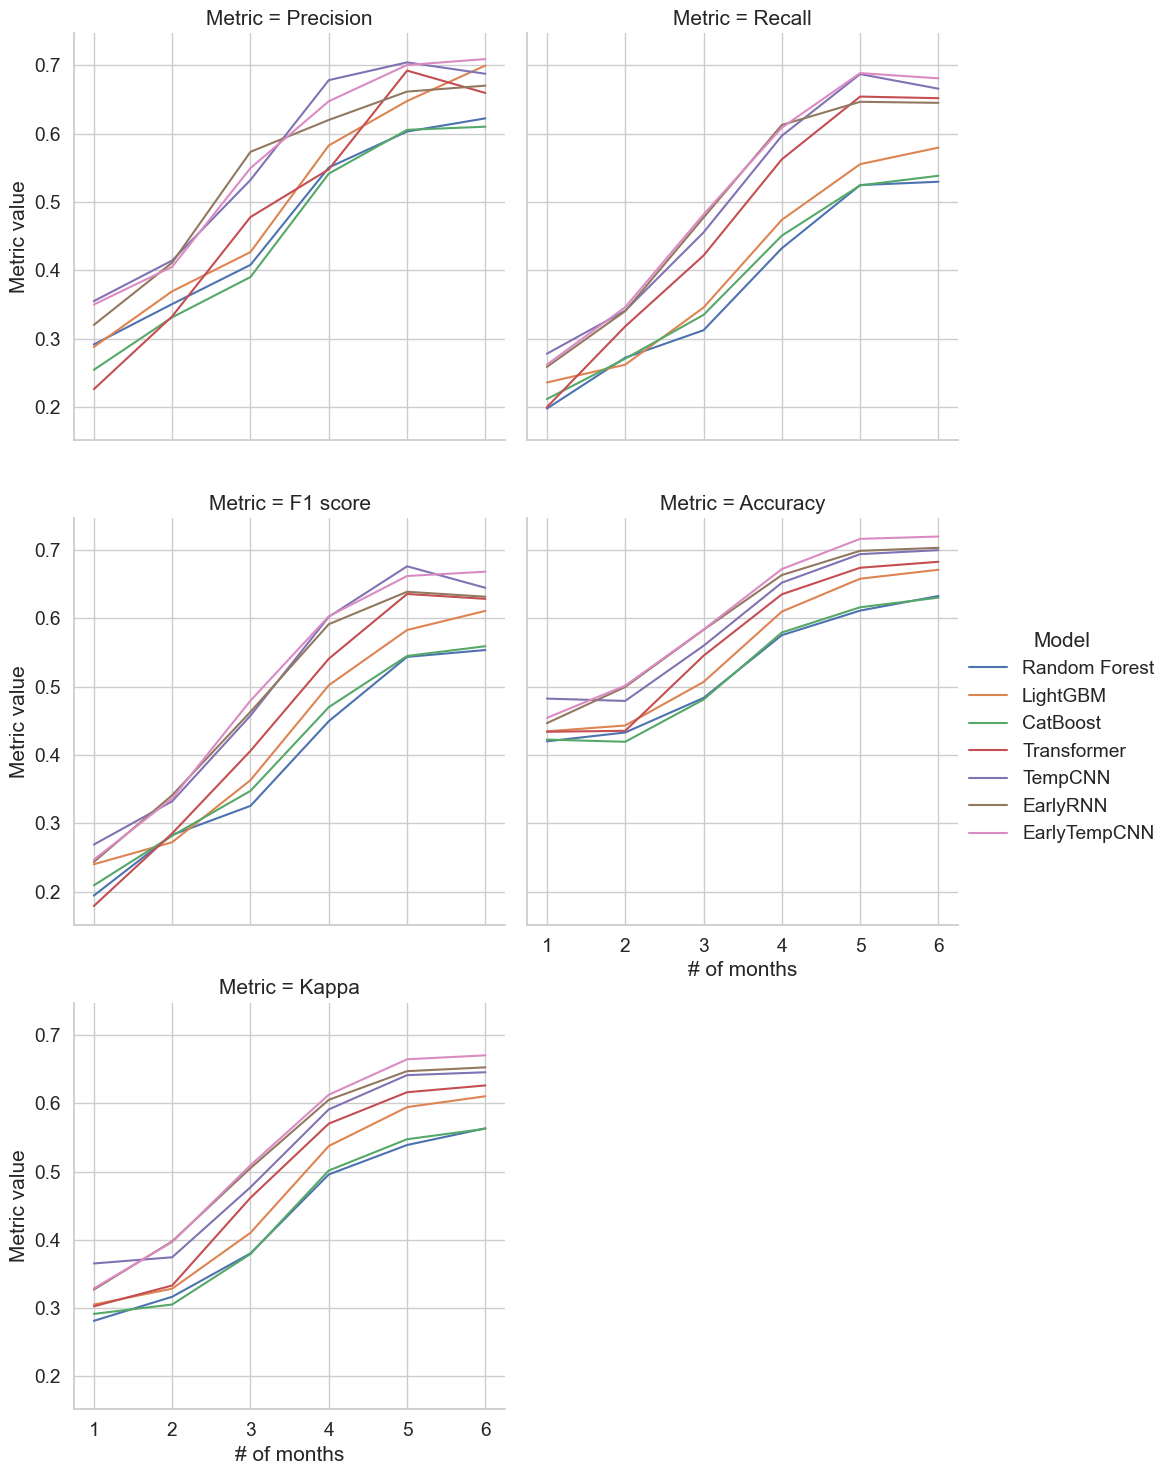

In [39]:
metrics_plot = sns.relplot(
    data=metrics_plot_data,
    x="# of months", y="Metric value", hue="Model", col="Metric", kind="line", col_wrap=2
)

In [40]:
metrics_plot.figure.savefig("metrics_plot.png", dpi=300)

# Part 3. Inference

In [8]:
from data.russia import Russia


ds = Russia(root="/home/pavel/elects_data/russia/", partition="test")

Data: test, year: 2018, months: 6
Loading from cache
# of fields: 2057


In [40]:
def plot_early_nn_predictions(dataset, model, index, T):
    X, y = dataset[index]
    model.eval()
    log_class_probabilities, probabilitiy_stopping = model(X[:T].unsqueeze(0))

    fig, axs = plt.subplots(2, 1, figsize=(16, 8))
    
    ax = axs[0]
    ax.plot(log_class_probabilities[0].exp().detach().numpy())
    ax.set_ylim(0, 1.05)
    ax.legend(ds.crops.values(), loc="upper left", bbox_to_anchor=(1.03, 1.03), fontsize=20)
    ax.set_title(f"Classification probabilities (correct class = {dataset.crops[y[0].item()]})", fontsize=24)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    
    ax = axs[1]
    ax.bar(x=np.arange(probabilitiy_stopping.shape[1]), height=probabilitiy_stopping[0].detach().numpy())
    ax.set_title("Stopping probability", fontsize=24)
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    
    plt.subplots_adjust(hspace=0.4)
    sns.despine(offset=0.2)
    
    return axs

In [41]:
with open(dumps_path / "earlyrnn_results.dump", "rb") as f:
    earlyrnn_results = pickle.load(f)
    earlyrnn_model = earlyrnn_results["best_model"]

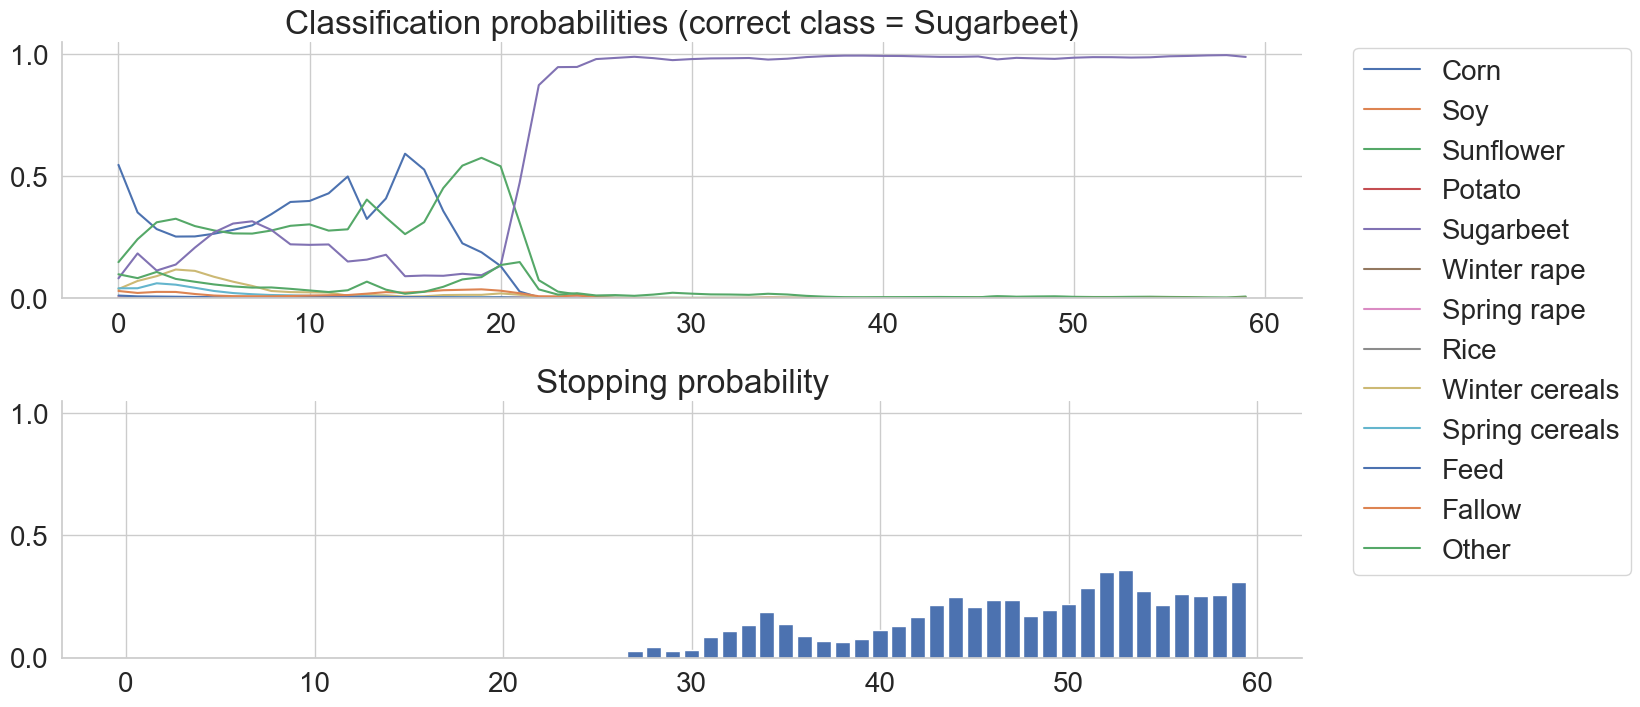

In [42]:
earlyrnn_preds, earlyrnn_stopping_prob = plot_early_nn_predictions(ds, earlyrnn_model, 10, 60)

In [84]:
earlyrnn_preds.figure.savefig("earlyrnn_preds.png", dpi=300, bbox_inches="tight")

In [43]:
with open(dumps_path / "earlytempcnn_results.dump", "rb") as f:
    earlytempcnn_results = pickle.load(f)
    earlytempcnn_model = earlytempcnn_results["best_model"]

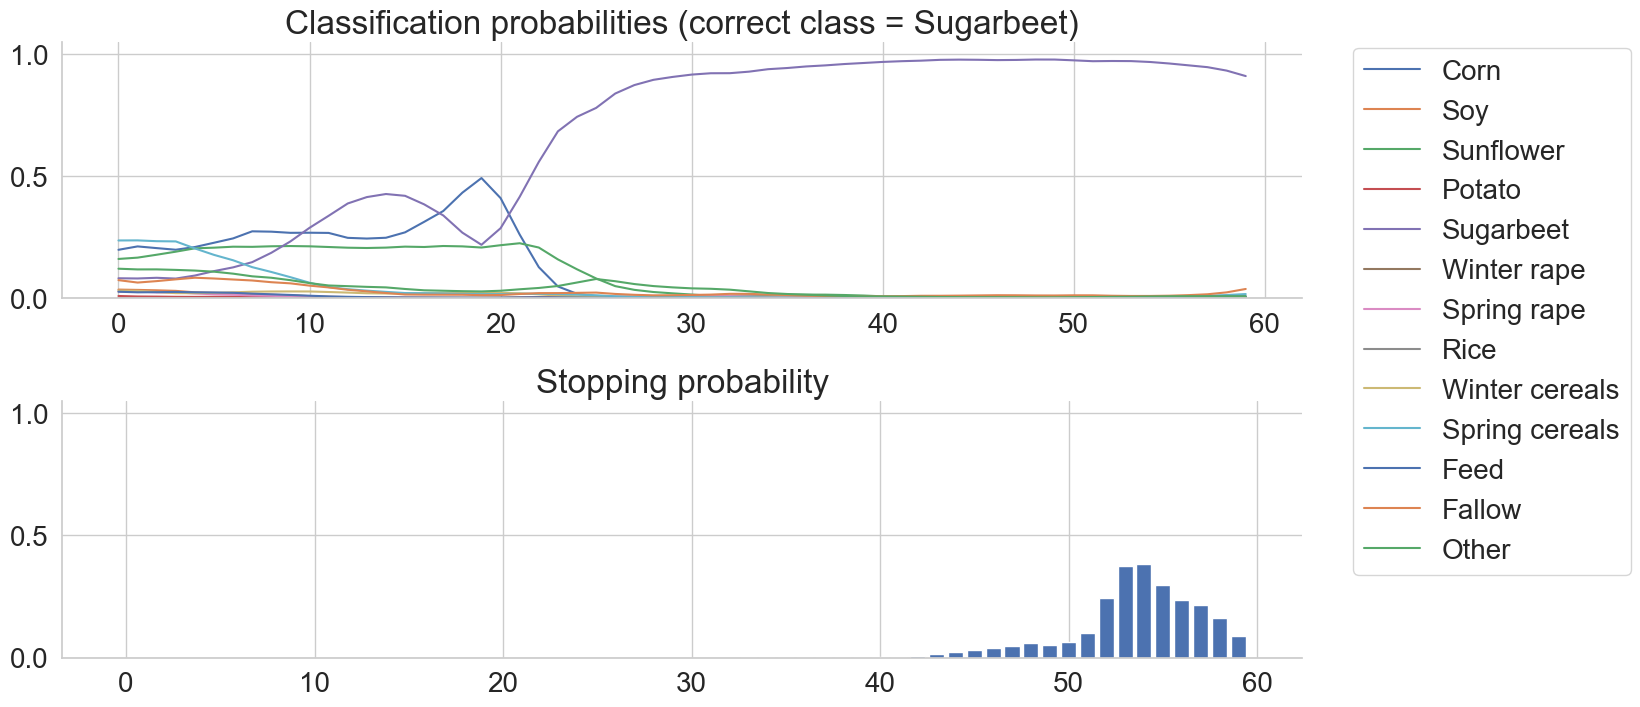

In [44]:
earlytempcnn_preds, earlytempcnn_stopping_prob = plot_early_nn_predictions(ds, earlytempcnn_model, 10, 60)

In [85]:
earlytempcnn_preds.figure.savefig("earlytempcnn_preds.png", dpi=300, bbox_inches="tight")

In [9]:
with open(dumps_path / "rf_results.dump", "rb") as f:
    rf_results = pickle.load(f)

In [33]:
def plot_tree_predictions(dataset, results, index, T):
    probabilities = []
    n_months = T // 10
    assert 1 <= n_months <= 6
    y = dataset["y"][index]
        
    for month in range(1, n_months + 1):
        model = results[month]["best_model"]
        X = dataset["X"][index, :month*100].reshape(1, -1)
        preds = model.predict_proba(X).flatten()
        probabilities.append(preds)
    
    probabilities = [[0.0 for i in range(len(probabilities[0]))]] + probabilities
    probs = np.array(probabilities)
    
    fig = plt.figure(figsize=(16, 6))
    plt.plot(probs)
    plt.title(f"Classification probabilities (correct class = {dataset.crops[y]})", fontsize=24)
    plt.legend(dataset.crops.values(), loc="upper left", bbox_to_anchor=(1.03, 1.03), fontsize=20)
    plt.ylim(0, 1.05)
    plt.xticks(ticks = range(probs.shape[0]), labels=[i * 10 for i in range(probs.shape[0])])
    plt.tick_params(axis="x", labelsize=20)
    plt.tick_params(axis="y", labelsize=20)
    sns.despine(offset=0.2)
    
    return fig

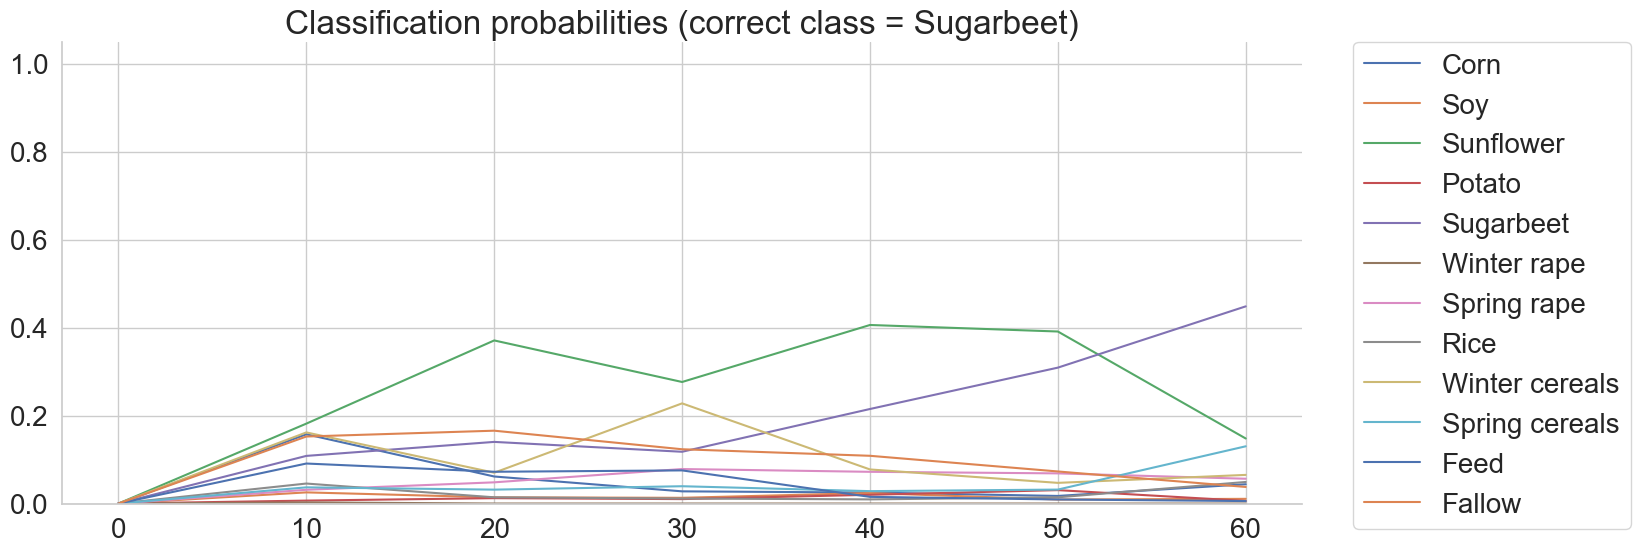

In [34]:
rf_preds = plot_tree_predictions(ds, rf_results, 10, 60)

In [35]:
rf_preds.savefig("rf_preds.png", dpi=300, bbox_inches="tight")

In [36]:
def plot_nn_predictions(dataset, results, index, T):
    probabilities = []
    n_months = T // 10
    assert 1 <= n_months <= 6
    y = dataset["y"][index]
        
    for month in range(1, n_months + 1):
        model = results[month]["best_model"]
        model.eval()
        X = dataset[index][0][None, :month*10]
        preds = model(X).exp().detach().numpy().flatten()
        probabilities.append(preds)
    
    probabilities = [[0.0 for i in range(len(probabilities[0]))]] + probabilities
    probs = np.array(probabilities)
    
    fig = plt.figure(figsize=(16, 6))
    plt.plot(probs)
    plt.title(f"Classification probabilities (correct class = {dataset.crops[y]})", fontsize=24)
    plt.legend(dataset.crops.values(), loc="upper left", bbox_to_anchor=(1.03, 1.03), fontsize=20)
    plt.ylim(0, 1.05)
    plt.xticks(ticks = range(probs.shape[0]), labels=[i * 10 for i in range(probs.shape[0])])
    plt.tick_params(axis="x", labelsize=20)
    plt.tick_params(axis="y", labelsize=20)
    sns.despine(offset=0.2)
    
    return fig

In [37]:
with open(dumps_path / "tempcnn_results.dump", "rb") as f:
    tempcnn_results = pickle.load(f)

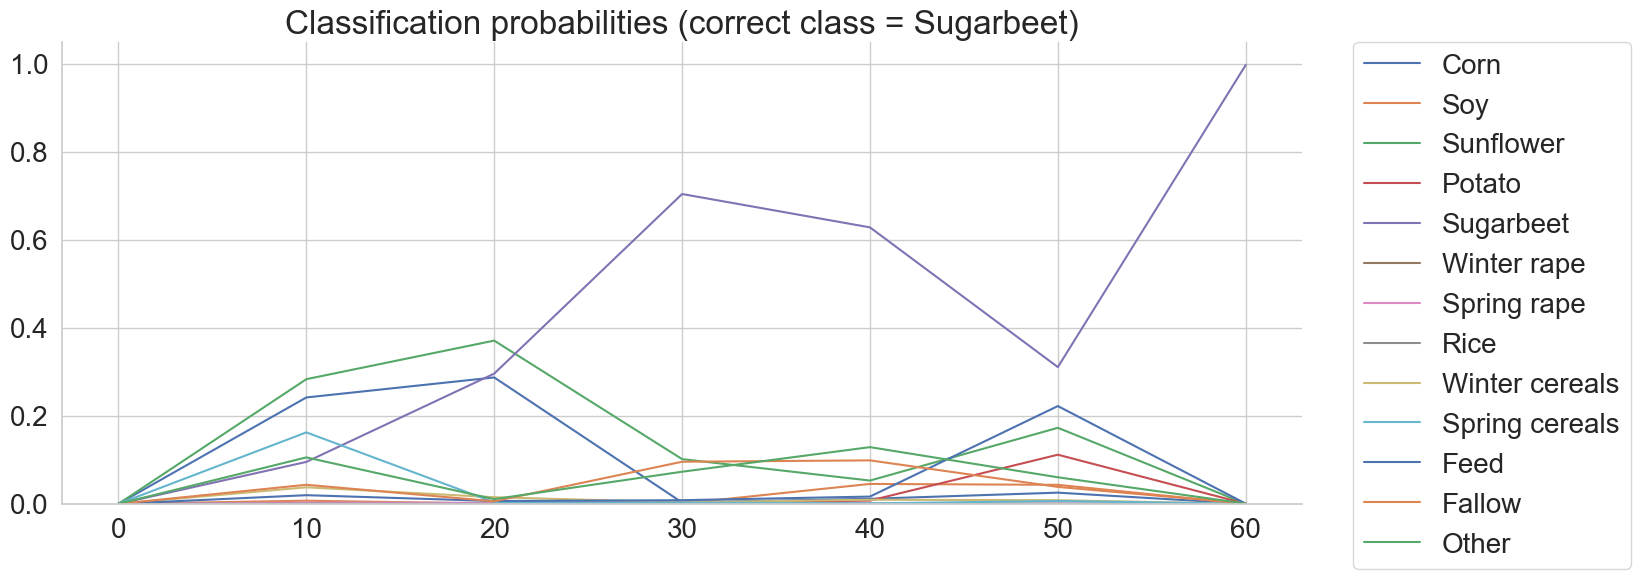

In [38]:
tempcnn_preds = plot_nn_predictions(ds, tempcnn_results, 10, 60)

In [39]:
tempcnn_preds.savefig("tempcnn_preds.png", dpi=300, bbox_inches="tight")

# Part 4. Robustness check

In [42]:
def retrain_trees(train_ds, test_ds, existing_model):
    X_train, y_train = train_ds["X"], train_ds["y"]
    print("Refitting model")
    existing_model.fit(X_train, y_train)
    
    print("Calculating scores")
    X_test, y_test = test_ds["X"], test_ds["y"]
    y_pred = existing_model.predict(X_test)
    precision, recall, fscore, support = sklearn.metrics.precision_recall_fscore_support(
                y_pred=y_pred, y_true=y_test, average="macro",
                zero_division=0)
    accuracy = sklearn.metrics.accuracy_score(y_pred=y_pred, y_true=y_test)
    kappa = sklearn.metrics.cohen_kappa_score(y_pred, y_test)

    train_stats = {
        "test_scores": {
            "precision": precision,
            "recall": recall,
            "fscore": fscore,
            "accuracy": accuracy,
            "kappa": kappa,
        }
    }

    return train_stats

In [43]:
def get_trees_stats_2021(previous_results):
    results = defaultdict(dict)

    for n_months in range(1, 7):
        sequencelength = n_months * TIMESTAMPS_PER_MONTH
        train_ds = Russia(
            root="/home/pavel/elects_data/russia/",
            sequencelength=sequencelength,
            partition="train",
            year=2021,
            broadcast_y=False,
            n_months=n_months
        )
        test_ds = Russia(
            root="/home/pavel/elects_data/russia/",
            sequencelength=sequencelength,
            partition="test",
            year=2021,
            broadcast_y=False,
            n_months=n_months
        )
        model = previous_results[n_months]["best_model"]
        stats = retrain_trees(train_ds, test_ds, model)
        results[n_months]["stats"] = stats
    
    return results

In [2]:
for n_months in range(4, 7):    
    train_ds = Russia(
        root="/home/pavel/elects_data/russia/",
        sequencelength=n_months * 10,
        partition="train",
        year=2021,
        broadcast_y=False,
        n_months=n_months
    )
    test_ds = Russia(
        root="/home/pavel/elects_data/russia/",
        sequencelength=n_months * 10,
        partition="test",
        year=2021,
        broadcast_y=False,
        n_months=n_months
    )

Data: train, year: 2021, months: 4
Loading from cache
# of fields: 30417
Data: test, year: 2021, months: 4
Loading from cache
# of fields: 7595
Data: train, year: 2021, months: 5
Loading from cache
# of fields: 30417
Data: test, year: 2021, months: 5
Loading from cache
# of fields: 7595
Data: train, year: 2021, months: 6
Reading from disk
Preprocessing features
Preparing X and y


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 30417/30417 [17:42<00:00, 28.62it/s]


# of fields: 30417
Data: test, year: 2021, months: 6
Reading from disk
Preprocessing features
Preparing X and y


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7595/7595 [02:30<00:00, 50.55it/s]


# of fields: 7595


In [22]:
rf_results_2021 = get_trees_stats_2021(rf_results)

Data: train, year: 2021, months: 1
Loading from cache
# of fields: 27914
Data: test, year: 2021, months: 1
Loading from cache
# of fields: 7432
Refitting model


KeyboardInterrupt: 

In [23]:
rf_results_2021

defaultdict(dict,
            {1: {'stats': {'test_scores': {'precision': 0.36,
                'recall': 0.24,
                'fscore': 0.24,
                'accuracy': 0.42,
                'kappa': 0.30}}},
             2: {'stats': {'test_scores': {'precision': 0.41,
                'recall': 0.33,
                'fscore': 0.34,
                'accuracy': 0.48,
                'kappa': 0.39}}},
             3: {'stats': {'test_scores': {'precision': 0.61,
                'recall': 0.49,
                'fscore': 0.52,
                'accuracy': 0.60,
                'kappa': 0.53}}},
             4: {'stats': {'test_scores': {'precision': 0.73,
                'recall': 0.61,
                'fscore': 0.65,
                'accuracy': 0.69,
                'kappa': 0.64}}},
             5: {'stats': {'test_scores': {'precision': 0.75,
                'recall': 0.64,
                'fscore': 0.68,
                'accuracy': 0.70,
                'kappa': 0.65}}},
            

In [24]:
with open(dumps_path / "rf_results_2021.json", "w") as f:
    json.dump(rf_results_2021, f)

In [16]:
lgbm_results_2021 = get_trees_stats_2021(lgbm_results)

Data: train, year: 2021, months: 1
Loading from cache
# of fields: 27914
Data: test, year: 2021, months: 1
Loading from cache
# of fields: 7432
Refitting model
Calculating scores
Data: train, year: 2021, months: 2
Loading from cache
# of fields: 30345
Data: test, year: 2021, months: 2
Loading from cache
# of fields: 7595
Refitting model
Calculating scores
Data: train, year: 2021, months: 3
Loading from cache
# of fields: 30417
Data: test, year: 2021, months: 3
Loading from cache
# of fields: 7595
Refitting model
Calculating scores
Data: train, year: 2021, months: 4
Loading from cache
# of fields: 30417
Data: test, year: 2021, months: 4
Loading from cache
# of fields: 7595
Refitting model
Calculating scores
Data: train, year: 2021, months: 5
Loading from cache
# of fields: 30417
Data: test, year: 2021, months: 5
Loading from cache
# of fields: 7595
Refitting model
Calculating scores
Data: train, year: 2021, months: 6
Loading from cache
# of fields: 30417
Data: test, year: 2021, months: 

In [30]:
lgbm_results_2021

defaultdict(dict,
            {1: {'stats': {'test_scores': {'precision': 0.39,
                'recall': 0.27,
                'fscore': 0.28,
                'accuracy': 0.44,
                'kappa': 0.33}}},
             2: {'stats': {'test_scores': {'precision': 0.46,
                'recall': 0.35,
                'fscore': 0.37,
                'accuracy': 0.51,
                'kappa': 0.42}}},
             3: {'stats': {'test_scores': {'precision': 0.64,
                'recall': 0.55,
                'fscore': 0.57,
                'accuracy': 0.66,
                'kappa': 0.60}}},
             4: {'stats': {'test_scores': {'precision': 0.76,
                'recall': 0.66,
                'fscore': 0.70,
                'accuracy': 0.74,
                'kappa': 0.70}}},
             5: {'stats': {'test_scores': {'precision': 0.79,
                'recall': 0.69,
                'fscore': 0.72,
                'accuracy': 0.75,
                'kappa': 0.71}}},
            

In [25]:
with open(dumps_path / "lgbm_results_2021.json", "w") as f:
    json.dump(lgbm_results_2021, f)

In [26]:
catboost_results_2021 = get_trees_stats_2021(catboost_results)

Data: train, year: 2021, months: 1
Loading from cache
# of fields: 27914
Data: test, year: 2021, months: 1
Loading from cache
# of fields: 7432
Refitting model
Learning rate set to 0.381517
0:	learn: 2.1804772	total: 168ms	remaining: 31.7s
50:	learn: 1.7039087	total: 4.53s	remaining: 12.3s
100:	learn: 1.6123304	total: 9.01s	remaining: 7.94s
150:	learn: 1.5554988	total: 13.5s	remaining: 3.49s
189:	learn: 1.5184969	total: 16.9s	remaining: 0us
Calculating scores
Data: train, year: 2021, months: 2
Loading from cache
# of fields: 30345
Data: test, year: 2021, months: 2
Loading from cache
# of fields: 7595
Refitting model
Learning rate set to 0.383145
0:	learn: 2.0257963	total: 360ms	remaining: 1m 7s
50:	learn: 1.4530244	total: 12.6s	remaining: 34.4s
100:	learn: 1.3399976	total: 24.5s	remaining: 21.6s
150:	learn: 1.2594530	total: 36.4s	remaining: 9.41s
189:	learn: 1.2070355	total: 46.6s	remaining: 0us
Calculating scores
Data: train, year: 2021, months: 3
Loading from cache
# of fields: 30417

In [28]:
with open(dumps_path / "catboost_results_2021.json", "w") as f:
    json.dump(catboost_results_2021, f)

In [29]:
catboost_results_2021

defaultdict(dict,
            {1: {'stats': {'test_scores': {'precision': 0.35,
                'recall': 0.25,
                'fscore': 0.25,
                'accuracy': 0.44,
                'kappa': 0.32}}},
             2: {'stats': {'test_scores': {'precision': 0.38,
                'recall': 0.34,
                'fscore': 0.35,
                'accuracy': 0.47,
                'kappa': 0.38}}},
             3: {'stats': {'test_scores': {'precision': 0.59,
                'recall': 0.51,
                'fscore': 0.53,
                'accuracy': 0.60,
                'kappa': 0.53}}},
             4: {'stats': {'test_scores': {'precision': 0.71,
                'recall': 0.63,
                'fscore': 0.66,
                'accuracy': 0.69,
                'kappa': 0.64}}},
             5: {'stats': {'test_scores': {'precision': 0.72,
                'recall': 0.66,
                'fscore': 0.68,
                'accuracy': 0.70,
                'kappa': 0.66}}},
            

In [8]:
transformer_results_2021 = defaultdict(dict)

for n_months in range(1, 7):
    sequencelength = n_months * TIMESTAMPS_PER_MONTH
    transformer_train_params_2021 = TrainConfig(
        epochs=50,
        model="transformer",
        year=2021,
        n_months=n_months,
        sequencelength=sequencelength
    )
    best_model, stats = train(transformer_train_params_2021)
    transformer_results_2021[n_months]["best_model"] = best_model.to("cpu")
    transformer_results_2021[n_months]["stats"] = stats

Data: train, year: 2021, months: 1
Loading from cache
# of fields: 27914
Data: test, year: 2021, months: 1
Loading from cache
# of fields: 7432
Total length of data: train=27914, test=7432
X shape: torch.Size([10, 10]) y shape: torch.Size([])


/media/pavel/DATA/miniconda3-ubuntu1604/envs/python310/lib/python3.10/site-packages/torch/cuda/__init__.py:87: UserWarning: 
    Found GPU0 GeForce GT 740M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))
epoch 50: trainloss 1.65, testloss 1.76, accuracy 0.44, earliness 0.00. classification loss 1.76, earliness reward 0.00. early stopping


Data: train, year: 2021, months: 2
Loading from cache
# of fields: 30345
Data: test, year: 2021, months: 2
Loading from cache
# of fields: 7595
Total length of data: train=30345, test=7595
X shape: torch.Size([20, 10]) y shape: torch.Size([])


epoch 50: trainloss 1.39, testloss 1.52, accuracy 0.49, earliness 0.00. classification loss 1.52, earliness reward 0.00. early stopping


Data: train, year: 2021, months: 3
Loading from cache
# of fields: 30417
Data: test, year: 2021, months: 3
Loading from cache
# of fields: 7595
Total length of data: train=30417, test=7595
X shape: torch.Size([30, 10]) y shape: torch.Size([])


epoch 50: trainloss 0.89, testloss 1.14, accuracy 0.66, earliness 0.00. classification loss 1.14, earliness reward 0.00. early stopping


Data: train, year: 2021, months: 4
Loading from cache
# of fields: 30417
Data: test, year: 2021, months: 4
Loading from cache
# of fields: 7595
Total length of data: train=30417, test=7595
X shape: torch.Size([40, 10]) y shape: torch.Size([])


epoch 50: trainloss 0.65, testloss 0.83, accuracy 0.77, earliness 0.00. classification loss 0.83, earliness reward 0.00. early stopping


Data: train, year: 2021, months: 5
Loading from cache
# of fields: 30417
Data: test, year: 2021, months: 5
Loading from cache
# of fields: 7595
Total length of data: train=30417, test=7595
X shape: torch.Size([50, 10]) y shape: torch.Size([])


epoch 50: trainloss 0.58, testloss 0.81, accuracy 0.77, earliness 0.00. classification loss 0.81, earliness reward 0.00. early stopping


Data: train, year: 2021, months: 6
Loading from cache
# of fields: 30417
Data: test, year: 2021, months: 6
Loading from cache
# of fields: 7595
Total length of data: train=30417, test=7595
X shape: torch.Size([60, 10]) y shape: torch.Size([])


epoch 50: trainloss 0.58, testloss 0.78, accuracy 0.79, earliness 0.00. classification loss 0.78, earliness reward 0.00. early stopping


In [12]:
with open(dumps_path / "transformer_results_2021.dump", "wb") as f:
    pickle.dump(transformer_results_2021, f)

In [7]:
tempcnn_results_2021 = defaultdict(dict)

for n_months in range(1, 7):
    sequencelength = n_months * TIMESTAMPS_PER_MONTH
    tempcnn_train_params_2021 = TrainConfig(
        epochs=50,
        model="tempcnn",
        year=2021,
        n_months=n_months,
        sequencelength=sequencelength
    )
    best_model, stats = train(tempcnn_train_params_2021)
    tempcnn_results_2021[n_months]["best_model"] = best_model.to("cpu")
    tempcnn_results_2021[n_months]["stats"] = stats

Data: train, year: 2021, months: 1
Loading from cache
# of fields: 27914
Data: test, year: 2021, months: 1
Loading from cache
# of fields: 7432
Total length of data: train=27914, test=7432
X shape: torch.Size([10, 10]) y shape: torch.Size([])


/media/pavel/DATA/miniconda3-ubuntu1604/envs/python310/lib/python3.10/site-packages/torch/cuda/__init__.py:87: UserWarning: 
    Found GPU0 GeForce GT 740M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))
epoch 40: trainloss 1.31, testloss 1.90, accuracy 0.42, earliness 0.00. classification loss 1.90, earliness reward 0.00. early stopping


stopping training. testloss 1.90 did not improve in 30 epochs.
Data: train, year: 2021, months: 2
Loading from cache
# of fields: 30345
Data: test, year: 2021, months: 2
Loading from cache
# of fields: 7595
Total length of data: train=30345, test=7595
X shape: torch.Size([20, 10]) y shape: torch.Size([])


epoch 40: trainloss 0.88, testloss 1.79, accuracy 0.51, earliness 0.00. classification loss 1.79, earliness reward 0.00. early stopping


stopping training. testloss 1.79 did not improve in 30 epochs.
Data: train, year: 2021, months: 3
Loading from cache
# of fields: 30417
Data: test, year: 2021, months: 3
Loading from cache
# of fields: 7595
Total length of data: train=30417, test=7595
X shape: torch.Size([30, 10]) y shape: torch.Size([])


epoch 50: trainloss 0.38, testloss 1.57, accuracy 0.63, earliness 0.00. classification loss 1.57, earliness reward 0.00. early stopping


stopping training. testloss 1.57 did not improve in 30 epochs.
Data: train, year: 2021, months: 4
Loading from cache
# of fields: 30417
Data: test, year: 2021, months: 4
Loading from cache
# of fields: 7595
Total length of data: train=30417, test=7595
X shape: torch.Size([40, 10]) y shape: torch.Size([])


epoch 46: trainloss 0.27, testloss 1.15, accuracy 0.74, earliness 0.00. classification loss 1.15, earliness reward 0.00. early stopping


stopping training. testloss 1.15 did not improve in 30 epochs.
Data: train, year: 2021, months: 5
Loading from cache
# of fields: 30417
Data: test, year: 2021, months: 5
Loading from cache
# of fields: 7595
Total length of data: train=30417, test=7595
X shape: torch.Size([50, 10]) y shape: torch.Size([])


epoch 35: trainloss 0.29, testloss 1.02, accuracy 0.77, earliness 0.00. classification loss 1.02, earliness reward 0.00. early stopping


stopping training. testloss 1.02 did not improve in 30 epochs.
Data: train, year: 2021, months: 6
Loading from cache
# of fields: 30417
Data: test, year: 2021, months: 6
Loading from cache
# of fields: 7595
Total length of data: train=30417, test=7595
X shape: torch.Size([60, 10]) y shape: torch.Size([])


epoch 38: trainloss 0.24, testloss 1.22, accuracy 0.74, earliness 0.00. classification loss 1.22, earliness reward 0.00. early stopping

stopping training. testloss 1.22 did not improve in 30 epochs.


In [12]:
with open(dumps_path / "tempcnn_results_2021.dump", "wb") as f:
    pickle.dump(tempcnn_results_2021, f)

In [8]:
N_MONTHS = 6

earlyrnn_results_2021 = defaultdict(dict)

earlyrnn_args_2021 = TrainConfig(
    epochs=50,
    year=2018,
    model="earlyrnn",
    n_months=N_MONTHS,
    sequencelength=N_MONTHS * TIMESTAMPS_PER_MONTH
)
best_model, stats = train(earlyrnn_args_2021)
earlyrnn_results_2021["best_model"] = best_model.to("cpu")
earlyrnn_results_2021["stats"] = stats

Data: train, year: 2018, months: 6
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 6
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([60, 10]) y shape: torch.Size([60])


epoch 50: trainloss 2.64, testloss 7.38, accuracy 0.67, earliness 0.41. classification loss 17.26, earliness reward 2.50. early stoppin


In [10]:
with open(dumps_path / "earlyrnn_results_2021.dump", "wb") as f:
    pickle.dump(earlyrnn_results_2021, f)

/media/pavel/DATA/miniconda3-ubuntu1604/envs/python310/lib/python3.10/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [9]:
N_MONTHS = 6

earlytempcnn_results_2021 = defaultdict(dict)

earlytempcnn_args_2021 = TrainConfig(
    epochs=50,
    year=2018,
    model="earlytempcnn",
    n_months=N_MONTHS,
    sequencelength=N_MONTHS * TIMESTAMPS_PER_MONTH
)
best_model, stats = train(earlytempcnn_args_2021)
earlytempcnn_results_2021["best_model"] = best_model.to("cpu")
earlytempcnn_results_2021["stats"] = stats

Data: train, year: 2018, months: 6
Loading from cache
# of fields: 8264
Data: test, year: 2018, months: 6
Loading from cache
# of fields: 2057
Total length of data: train=8264, test=2057
X shape: torch.Size([60, 10]) y shape: torch.Size([60])


epoch 48: trainloss 3.25, testloss 7.28, accuracy 0.70, earliness 0.38. classification loss 17.04, earliness reward 2.48. early stoppin

stopping training. testloss 7.28 did not improve in 30 epochs.


In [11]:
with open(dumps_path / "earlytempcnn_results_2021.dump", "wb") as f:
    pickle.dump(earlytempcnn_results_2021, f)

In [44]:
with open(dumps_path / "rf_results_2021.json", "r") as f:
    rf_results_2021 = json.load(f)

rf_test_scores_2021 = get_test_scores(rf_results_2021)
rf_test_scores_2021

precision  recall  fscore  accuracy  kappa
n_months                                            
1              0.36    0.24    0.24      0.42   0.30
2              0.41    0.33    0.34      0.48   0.39
3              0.61    0.49    0.52      0.60   0.53
4              0.73    0.61    0.65      0.69   0.64
5              0.75    0.64    0.68      0.70   0.65
6              0.75    0.63    0.67      0.69   0.64

In [45]:
with open(dumps_path / "lgbm_results_2021.json", "r") as f:
    lgbm_results_2021 = json.load(f)

lgbm_test_scores_2021 = get_test_scores(lgbm_results_2021)
lgbm_test_scores_2021

precision  recall  fscore  accuracy  kappa
n_months                                            
1              0.39    0.27    0.28      0.44   0.33
2              0.46    0.35    0.37      0.51   0.42
3              0.64    0.55    0.57      0.66   0.60
4              0.76    0.66    0.70      0.74   0.70
5              0.79    0.69    0.72      0.75   0.71
6              0.79    0.68    0.71      0.74   0.69

In [46]:
with open(dumps_path / "catboost_results_2021.json", "r") as f:
    catboost_results_2021 = json.load(f)

catboost_test_scores_2021 = get_test_scores(catboost_results_2021)
catboost_test_scores_2021

precision  recall  fscore  accuracy  kappa
n_months                                            
1              0.35    0.25    0.25      0.44   0.32
2              0.38    0.34    0.35      0.47   0.38
3              0.59    0.51    0.53      0.60   0.53
4              0.71    0.63    0.66      0.69   0.64
5              0.72    0.66    0.68      0.70   0.66
6              0.71    0.64    0.66      0.69   0.64

In [47]:
with open(dumps_path / "transformer_results_2021.dump", "rb") as f:
    transformer_results_2021 = pickle.load(f)

transformer_test_scores_2021 = get_nn_test_scores(transformer_results_2021)
transformer_test_scores_2021

accuracy  precision  recall  fscore  kappa
n_months                                            
1             0.46       0.30    0.33    0.28   0.35
2             0.51       0.44    0.38    0.38   0.43
3             0.67       0.66    0.63    0.62   0.62
4             0.78       0.77    0.77    0.75   0.74
5             0.78       0.80    0.79    0.78   0.75
6             0.79       0.80    0.81    0.79   0.76

In [48]:
with open(dumps_path / "tempcnn_results_2021.dump", "rb") as f:
    tempcnn_results_2021 = pickle.load(f)

tempcnn_test_scores_2021 = get_nn_test_scores(tempcnn_results_2021)
tempcnn_test_scores_2021

accuracy  precision  recall  fscore  kappa
n_months                                            
1             0.46       0.41    0.33    0.32   0.36
2             0.52       0.46    0.41    0.42   0.44
3             0.69       0.70    0.64    0.65   0.64
4             0.77       0.77    0.75    0.75   0.74
5             0.77       0.79    0.79    0.78   0.74
6             0.78       0.81    0.79    0.78   0.74

In [49]:
with open(dumps_path / "earlyrnn_results_2021.dump", "rb") as f:
    earlyrnn_results_2021 = pickle.load(f)

earlyrnn_stats_2021, earlyrnn_monthly_scores_2021 = get_early_nn_stats(earlyrnn_results_2021)
earlyrnn_monthly_scores_2021

accuracy  precision  recall  fscore  kappa
n_months                                            
1             0.45       0.32    0.28    0.27   0.33
2             0.50       0.43    0.34    0.35   0.39
3             0.59       0.54    0.48    0.48   0.51
4             0.66       0.62    0.60    0.60   0.60
5             0.70       0.65    0.64    0.63   0.65
6             0.70       0.67    0.67    0.64   0.65

In [50]:
with open(dumps_path / "earlytempcnn_results_2021.dump", "rb") as f:
    earlytempcnn_results_2021 = pickle.load(f)

earlytempcnn_stats_2021, earlytempcnn_monthly_scores_2021 = get_early_nn_stats(earlytempcnn_results_2021)
earlyrnn_monthly_scores_2021

accuracy  precision  recall  fscore  kappa
n_months                                            
1             0.45       0.32    0.28    0.27   0.33
2             0.50       0.43    0.34    0.35   0.39
3             0.59       0.54    0.48    0.48   0.51
4             0.66       0.62    0.60    0.60   0.60
5             0.70       0.65    0.64    0.63   0.65
6             0.70       0.67    0.67    0.64   0.65

In [51]:
joint_test_scores_2021 = join_test_scores(
    dict(
        rf=rf_test_scores_2021,
        lgbm=lgbm_test_scores_2021,
        catboost=catboost_test_scores_2021,
        transformer=transformer_test_scores_2021,
        tempcnn=tempcnn_test_scores_2021,
        earlyrnn=earlyrnn_monthly_scores_2021,
        earlytempcnn=earlytempcnn_monthly_scores_2021
    )
)
joint_test_scores_2021

n_months         model  precision  recall  fscore  accuracy  kappa
0          1            rf       0.36    0.24    0.24      0.42   0.30
1          2            rf       0.41    0.33    0.34      0.48   0.39
2          3            rf       0.61    0.49    0.52      0.60   0.53
3          4            rf       0.73    0.61    0.65      0.69   0.64
4          5            rf       0.75    0.64    0.68      0.70   0.65
5          6            rf       0.75    0.63    0.67      0.69   0.64
6          1          lgbm       0.39    0.27    0.28      0.44   0.33
7          2          lgbm       0.46    0.35    0.37      0.51   0.42
8          3          lgbm       0.64    0.55    0.57      0.66   0.60
9          4          lgbm       0.76    0.66    0.70      0.74   0.70
10         5          lgbm       0.79    0.69    0.72      0.75   0.71
11         6          lgbm       0.79    0.68    0.71      0.74   0.69
12         1      catboost       0.35    0.25    0.25      0.44   0.32
13         2      catboost       0.38    0.34    0.35      0.47   0.38
14         3      catboost       0.59    0.51    0.53      0.60   0.53
15         4      catboost       0.71    0.63    0.66      0.69   0.64
16         5      catboost       0.72    0.66    0.68      0.70   0.66
17         6      catboost       0.71    0.64    0.66      0.69   0.64
18         1   transformer       0.30    0.33    0.28      0.46   0.35
19         2   transformer       0.44    0.38    0.38      0.51   0.43
20         3   transformer       0.66    0.63    0.62      0.67   0.62
21         4   transformer       0.77    0.77    0.75      0.78   0.74
22         5   transformer       0.80    0.79    0.78      0.78   0.75
23         6   transformer       0.80    0.81    0.79      0.79   0.76
24         1       tempcnn       0.41    0.33    0.32      0.46   0.36
25         2       tempcnn       0.46    0.41    0.42      0.52   0.44
26         3       tempcnn       0.70    0.64    0.65      0.69   0.64
27         4       tempcnn       0.77    0.75    0.75      0.77   0.74
28         5       tempcnn       0.79    0.79    0.78      0.77   0.74
29         6       tempcnn       0.81    0.79    0.78      0.78   0.74
30         1      earlyrnn       0.32    0.28    0.27      0.45   0.33
31         2      earlyrnn       0.43    0.34    0.35      0.50   0.39
32         3      earlyrnn       0.54    0.48    0.48      0.59   0.51
33         4      earlyrnn       0.62    0.60    0.60      0.66   0.60
34         5      earlyrnn       0.65    0.64    0.63      0.70   0.65
35         6      earlyrnn       0.67    0.67    0.64      0.70   0.65
36         1  earlytempcnn       0.33    0.26    0.25      0.45   0.33
37         2  earlytempcnn       0.42    0.33    0.32      0.49   0.39
38         3  earlytempcnn       0.54    0.47    0.46      0.58   0.51
39         4  earlytempcnn       0.66    0.61    0.60      0.68   0.63
40         5  earlytempcnn       0.71    0.69    0.68      0.72   0.67
41         6  earlytempcnn       0.71    0.71    0.66      0.72   0.67

In [52]:
fscores_2021 = joint_test_scores_2021[["n_months", "model", "fscore"]]\
    .pivot(columns="model", index="n_months", values="fscore")
fscores_2021

model     catboost  earlyrnn  earlytempcnn  lgbm    rf  tempcnn  transformer
n_months                                                                    
1             0.25      0.27          0.25  0.28  0.24     0.32         0.28
2             0.35      0.35          0.32  0.37  0.34     0.42         0.38
3             0.53      0.48          0.46  0.57  0.52     0.65         0.62
4             0.66      0.60          0.60  0.70  0.65     0.75         0.75
5             0.68      0.63          0.68  0.72  0.68     0.78         0.78
6             0.66      0.64          0.66  0.71  0.67     0.78         0.79

In [39]:
print(fscores_2021.to_latex(
        caption="F1-Scores of Models Depending on the Number of Months Based on 2021 Data",
        label="Table 4.4.1"))

\begin{table}
\centering
\caption{F1-Scores of Models Depending on the Number of Months Based on 2021 Data}
\label{Table 4.4.1}
\begin{tabular}{lrrrrrrr}
\toprule
model &  catboost &  earlyrnn &  earlytempcnn &  lgbm &    rf &  tempcnn &  transformer \\
n\_months &           &           &               &       &       &          &              \\
\midrule
1        &      0.25 &      0.27 &          0.25 &  0.28 &  0.24 &     0.32 &         0.28 \\
2        &      0.35 &      0.35 &          0.32 &  0.37 &  0.34 &     0.42 &         0.38 \\
3        &      0.53 &      0.48 &          0.46 &  0.57 &  0.52 &     0.65 &         0.62 \\
4        &      0.66 &      0.60 &          0.60 &  0.70 &  0.65 &     0.75 &         0.75 \\
5        &      0.68 &      0.63 &          0.68 &  0.72 &  0.68 &     0.78 &         0.78 \\
6        &      0.66 &      0.64 &          0.66 &  0.71 &  0.67 &     0.78 &         0.79 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_3339/564652868.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(fscores_2021.to_latex(


In [53]:
metrics_plot_data_2021 = joint_test_scores_2021\
    .melt(id_vars=["n_months", "model"], var_name="metric")\
    .transform({
        "n_months": lambda x: x,
        "model": lambda x: MODELS_LABELS[x],
        "metric": lambda x: x.title() if x != "fscore" else "F1 score",
        "value": lambda x: x
    })\
    .rename(columns={
                "n_months": "# of months",
                "model": "Model",
                "metric": "Metric",
                "value": "Metric value"}
           )
metrics_plot_data_2021

# of months          Model     Metric  Metric value
0              1  Random Forest  Precision          0.36
1              2  Random Forest  Precision          0.41
2              3  Random Forest  Precision          0.61
3              4  Random Forest  Precision          0.73
4              5  Random Forest  Precision          0.75
..           ...            ...        ...           ...
205            2   EarlyTempCNN      Kappa          0.39
206            3   EarlyTempCNN      Kappa          0.51
207            4   EarlyTempCNN      Kappa          0.63
208            5   EarlyTempCNN      Kappa          0.67
209            6   EarlyTempCNN      Kappa          0.67

[210 rows x 4 columns]

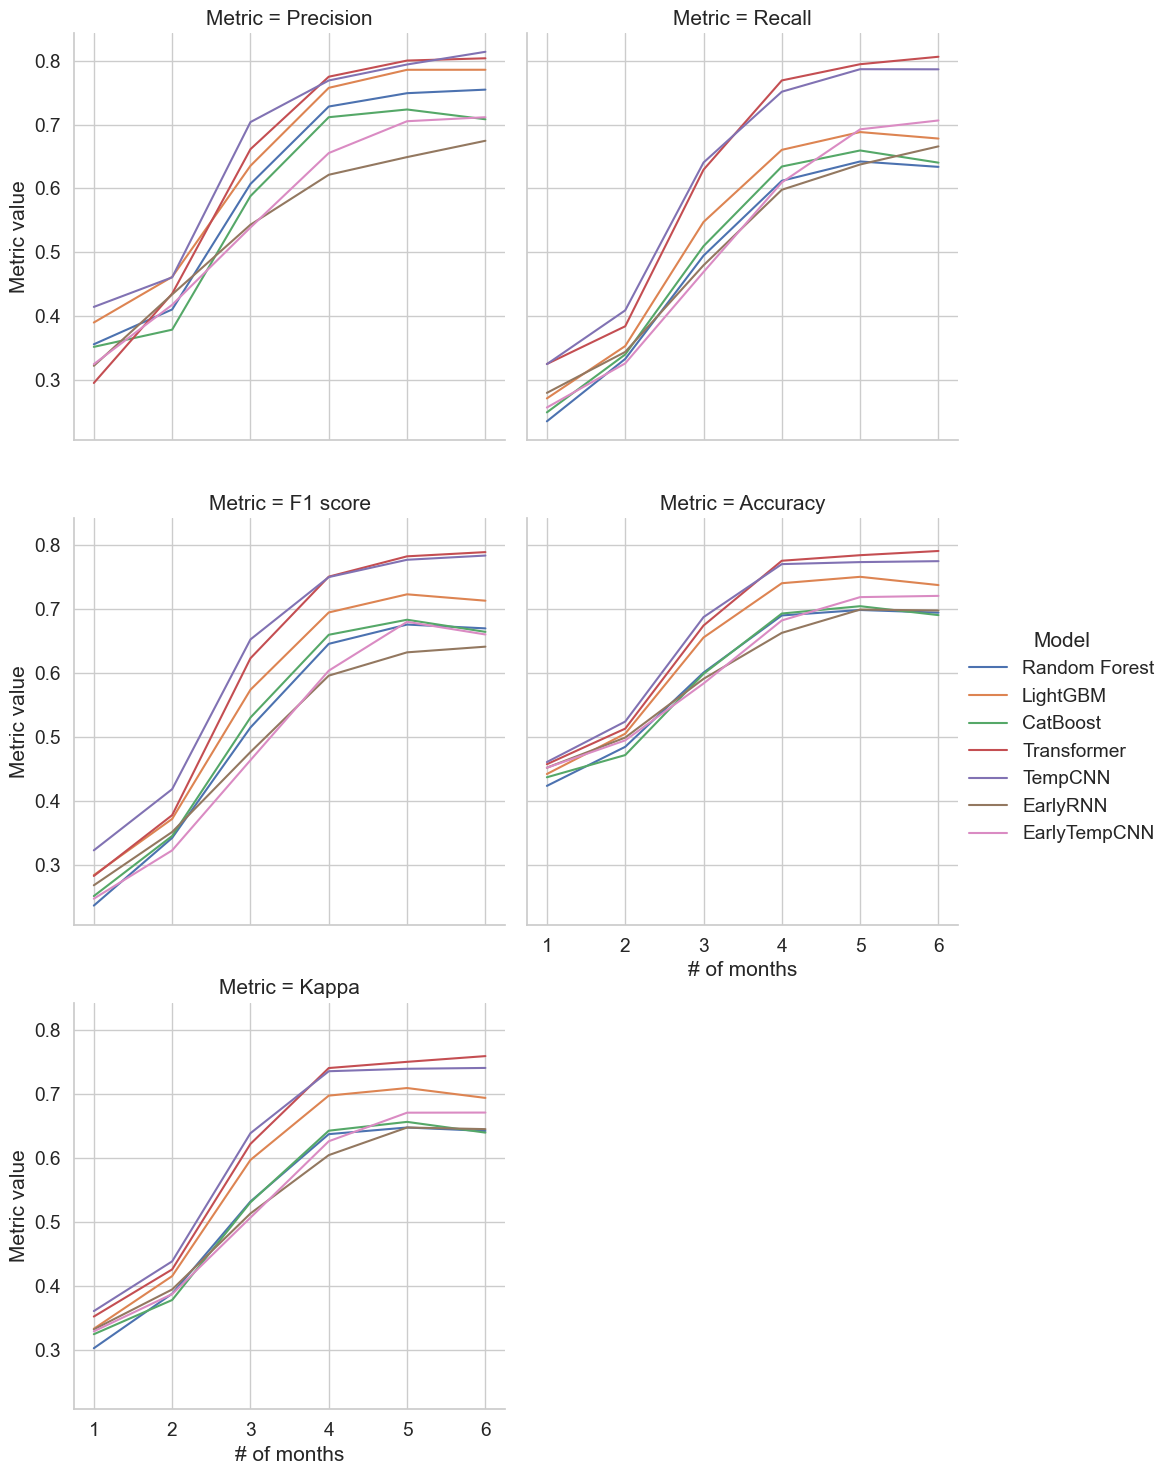

In [54]:
metrics_plot_2021 = sns.relplot(
    data=metrics_plot_data_2021,
    x="# of months", y="Metric value", hue="Model", col="Metric", kind="line", col_wrap=2
)

In [55]:
metrics_plot_2021.figure.savefig("metrics_plot_2021.png", dpi=300)